In [1]:
#use extinction environment

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import scipy.integrate as integrate
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
import random
from tqdm import tqdm
import lmfit
import glob
import re
import pickle
from astropy.table import Table, Column, MaskedColumn, join, vstack
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import  join_skycoord
from astropy import table
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, join, vstack
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#for multiprocessing
from joblib import Parallel, delayed

import sys
import os
sys.path.append('Software')
import WD_models
from corv_nicole.utils import build_montreal_da
sys.path.append('Software/pyphot')
import pyphot

plt.style.use('Software/stefan.mplstyle')

We could not find the pickled WD models
Please enter a new path to the Koester models.
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.


In [2]:
cCGS=2.99792458*10**10 #cm/s
speed_light = 299792458 #m/s
radius_sun = 6.957e8 #m
mass_sun = 1.9884e30 #kg
newton_G = 6.674e-11 #m^3⋅kg^-1⋅s^-2
pc_to_m = 3.086775e16
MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2

#physical constants in CGS units
c = 2.998e10 #cm/s
k = 1.38e-16 #erg/K
h = 6.626e-27 #erg s

#Balmer series line centroids, for vacuum wavelengths
halpha = 6564.61 #ang
hbeta = 4862.68 #ang
hgamma = 4341.68 #ang
hdelta = 4102.89 #ang

#physical constants in SI units
speed_light = 299792458 #m/s
radius_sun = 6.957e8 #m
mass_sun = 1.9884e30 #kg
newton_G = 6.674e-11 #N m^2/kg^2
pc_to_m = 3.086775e16


# This notebook creates a sample of 10,000 binaries and then characterizes the effect of binarity on SDSS and Gaia photometric fits

# Proportion of WDs in Binaries

### Holberg 2009
- Several general categories of binary systems involving white dwarfs are recognized: Sirius- like systems, where the white dwarf may be difficult to detect, binary systems containing white dwarfs and low mass stars, where the white  dwarf is often readily discerned; and double degenerate systems. 
- Different modes of white  dwarf discovery influence our perception of both the overall binary fraction and the nature of these systems; proper motion surveys emphasize resolved systems, while photometric surveys emphasize unresolved systems containing relatively hot white dwarf
- A sample of 132 white dwarfs within 20 pc  indicates that an individual white dwarf has a probability of 32  ±  8% of occurring within a  binary or multiple star system
- Of the 132 WDs in the local sample 92 (70%) are single stars, 16 (12%) are WD+dM, 10 (8%) are Sirius-like, and 7 (3 resolved and 4 unresolved=5%+5%) are in WD+WD binaries.

### Toonen 2017
- We model the formation and evolution of single stars and binaries within 20 pc with a population synthesis approach. We construct a model of the current sample of WDs and differentiate between WDs in different configurations, that is single WDs, and resolved and unresolved binaries containing a WD with either a main-sequence (MS) component or with a second WD. 
- The observed space densities of single and binary WDs are well reproduced by the models.
- Unresolved DWD candidates can be 
    - overly bright for their parallax/distance
    - have RV variations/broadened lines
    - lower measured gravity/mass from the photometric technique (=larger radius)
- Table 4: Of the observed WDs in the sample, 97 (78-80%) are single WDs, 20 (16-17%) are in resolved or unresolved WDMS binaries, 2 (2%) are in resolved DWD binaries, and 1-5 (1-4%) are in unresolved DWD binaries.
- The fraction of magnetic WDs amongst all WDs is poorly estimated due to selection effects, but it ranges from 21 ± 8% within 13 pc and 13 ± 4% within 20 pc from Kawka et al. (2007), to 8% from Sion et al. (2014). 
- Maxted & Marsh (1999) find a 95% probability that the fraction of double degenerates among DA WDs lies in the range 1.7–19%
- From the Sloan digital sky survey (SDSS), a binary fraction of 3–20% has been derived for separations less than 0.05 AU (Badenes & Maoz 2012), and for the SPY survey a fraction of 10.3% ± 1.7% (random uncertainty) ±1.5% (systematic uncertainty) for separations less than 4 AU

### Torres 2022
- In particular, our studies show that the sample up to 100 pc from the Sun can be considered as practically complete. This fact allows us to estimate a precise fraction of resolved double-degenerate (1.18 ± 0.10 per cent) and white dwarf plus main-sequence stars (6.31 ± 0.23 per cent) among all white dwarfs through comoving pairs identification.
- As sub-products of our modelling, we find that around 1 ∼ 3 per cent of the white dwarf population are unresolved double-degenerates and that only ∼1 per cent of all white dwarfs contain a He-core
- we adopt a conservative value of 2.75 arcsec as our boundary limit for both, WDMS and DWD, resolved systems
- the percentages (number of objects) of resolved WDMS and DWD we deduced from El-Badry & Rix (2018) are 7.11 per cent (980) and 1.29 per cent (176), respectively, which are in very good agreement with our estimates
- the percentage of resolved DWD found for the 100 pc sample is, although slightly smaller, in agreement with the 1.7 per cent found in the 20 pc sample by Toonen et al. (2017)
- the expected percentage of He-core stars is moderately low among the whole population, representing only ∼1 per cent, although within the DWD and WDMS sub-populations it represents ≈23 per cent and 14, respectively
    - White dwarfs with masses below 0.5 Msun can be safely considered helium-core white dwarf candidates (e.g. Althaus et al. 2010). We have marked in Fig. 5 as open symbols those objects with presumably helium-cores, founding 119 WDMS and 35 DWD of these systems, which represent 15 and 17 per cent of its respective sub-population.
- Another feature that we can analyse is the final orbital separation distribution, a, for resolved DWD and WDMS systems. In Fig. 6, we show the distribution of s for WDMS (top panel) and DWD (bottom panel) obtained from our observed EDR3 sample (grey histogram) and that presented in El-Badry & Rix (2018) (EBR18; green histogram) for objects closer than 100 pc with those synthetically derived from our best-fitting model 29 (red histogram) and Model 30 (blue histogram).
- Several studies have been performed during the last decades devoted to obtain an unbiased mass distribution (e.g. Bergeron, Saffer & Liebert 1992; Kepler et al. 2007; Rebassa-Mansergas et al. 2015a, 2015b; Tremblay et al. 2016; McCleery et al. 2020). The recent availability of Gaia data seems to indicate that, apart from a clear peak around 0.6 Msun, the distribution presents a bump around 0.8 Msun (Jim ́ enez-Esteban et al. 2018; Kilic et al. 2020).

# My work
- SnowWhite classifies whether WDs are in WDMS binaries, so assume any WDMS binary contamination is negligible
- SnowWhite does not classify double degenerate binaries, so assume all binary contamination is due to double degenerates
- Torres 2022: For Gaia resolving power, ~1% of all WDs are in resolved DWD binaries and ~1-3% of all WDs are in unresolved binaries.
- Assume the worst case scenario, that all DWD binaries are unresolved. This means that <5% of all WDs are actually DWDs (ignoring the fact that the SDSS sample is not complete)

# Distribution of DWD binary oribital separations
### Maoz 2018
- combine the constraints on the DWD population from SDSS, which with its low spectral resolution probes systems at separations 0.001 au< a < 0.05 au, and SPY, which with its high spectral resolution is sensitive to 0.05 au<a < 4 au.
- From a joint likelihood analysis, the DWD fraction among WDs is frac = 0.095 ± 0.020 (1σ , random) +0.010 (systematic) in the separation range <4 au.
- The index of a power-law distribution of INITIAL WD separations (at the start of solely gravitational wave-driven binary evolution), N(a)da ∝ a^α da,is α =−1.30 ± 0.15 (1σ ) +0.05 (systematic).
- Each simulated WD has a probability fbin to be in a DWD system with separation within amax, and a probability (1 −fbin) to be single. If an initial draw determines that the simulated WD is in a binary, the physical DWD system parameters are then chosen: the mass m1 of the WD (drawn from an observationally informed mass function); the mass m2 of the companion WD (drawn from a mass-ratio distribution); and the binary separation a (drawn from a separation distribution N(a)da). It is assumed that, at the time these binaries first become close DWDs, after their final common envelope phase, the DWD distribution of separations can be approximated as a power law with index α.
- Orbital decay resulting from gravitational-wave emission will modify this initial separation distribution with time, and, furthermore, the DWD separation distribution today will be the combination, over the lifetime of the Galaxy, of the evolved distributions from many populations of different ages. M12 showed that this results in a present-day separation distribution
$$ N (x)\propto x^{4+α}[(1 + x^{−4})^{(α+1)/4} − 1], α\neq−1$$
$$ N (x)\propto x^{3}\ln{(1 + x^{−4})}, α=−1$$
$$x=a/(Kt_0)^{1/4}$$
$$K=\frac{256}{5}\frac{G^3}{c^5}m_1m_2(m_1+m_2)$$
    where $t_0$ is the age of the galaxy
- The present-day distribution N(x)dx is approximately a broken power law, with index α at x>>1. At x<<1 the powerlaw index is 3 for α ≥−1, and α + 4 for α ≤−1. For each simulated DWD system, a is drawn from N(x), between amin = 2 × 10^4 km (DWD contact) and amax. Kepler’s law then gives the period and the (assumed circular) orbital velocities.
- Every simulated DWD system is then ‘observed’, by drawing for it a line-of-sight inclination of the orbital plane, choosing which of the two WDs is the photometric primary whose RV will be measured, and sampling the line-of-sight velocity (i.e. RV) curve of the photometric primary with a particular observation pattern (number of epochs and time between epochs) chosen at random from the set of real observing patterns of the real observed sample. Every simulated velocity measurement is noised with a random RV error, drawn from the distribution of measurement errors of the observed sample.
- For this calculation we used N(x) from equations (1)–(4), with a MW lifetime of t0 = 10 Gyr, and with the mean values of m1 and m2 from the simulations, which gives a turnover separation in the distribution, namely x = 1, that corresponds to a = 0.0107 au.
- Toonen et al. (2017) have recently studied WD binarity in a local 20-pc sample, and compared it with their binary population synthesis predictions. Among their findings, they estimate that the observed fraction of WDs in angularly ‘resolved DWD’ systems, which in their sample corresponds to separations of roughly 10^1-10^4 au, is about 1.5–2 per cent, an order of magnitude less than the value Toonen et al. (2017) expect from their models. If the powerlaw separation distribution that we have assumed extends out to large separations with the same best-fit index that we have found, α ≈−1.3, then the binary fraction at <4 au that we have measured, 8.5–11 per cent, corresponds to a factor of ∼7 fewer DWD systems at 10^1–10^4 au, namely 1–1.6 per cent, in good agreement with the observed resolved DWD fraction

### Maoz 2012
- Source of above equations in Maoz 2018
- For example, for t0 = 10 Gyr and m1 = m2 = 0.55 Msun, x = 1 corresponds to a0 = 0.01 AU, or 1.5 × 10^6 km, or about 150 WD radii.
- we draw the separation of specific component binary masses from the present-day distribution for a particular value of α, with a between amin = 2 × 10^4 km (contact) and amax = 0.05 AU
- Given two masses and an orbital separation, Kepler’s law gives the period
    $$\tau=2\pi\left(\frac{a^3}{G(m_1+m_2)}\right)^{1/2}$$
    and the circular orbital velocities
    $$v_1=\frac{2\pi a}{\tau}\frac{m_2}{m_1+m_2}$$ and $$v_2=\frac{2\pi a}{\tau}\frac{m_1}{m_1+m_2}$$
- We assume circular velocities for simplicity, but also because this is the expectation for close binaries that have likely undergone circularization by tidal forces and common-envelope evolution
- First, a line-of-sight inclination i of the perpendicular to the orbital plane is chosen from a distribution
$$P(i)\propto \sin{i}$$
    and the line-of-sight velocity is reduced by sin i
- We then need to decide which of the two WDs will be the photometric primary. This could be either the less massive WD, because it has larger surface area and/or it is younger and hence hotter, or the more massive WD, because it cools more slowly due to its small surface area and is hence hotter... it seems reasonable to assume that low-mass WDs, if present, will have a tendency to dominate the spectral energy distribution of DD systems, but in other cases either of the components may be dominant

### Korol 2022
- Using parallax-based distances we convert the excess of reduced χ 2 into the amplitude of the centroid wobble δa, which is proportional to the binary separation a.
- The integral of the distribution yields DWD fraction of 6.5 ± 3.7 per cent in the range 0.01 < a (au) < 2.
- Using synthetic models of the Galactic DWDs we demonstrate that the break in the δa distribution corresponds to one side of a deep gap in the DWD separation distribution at around a ≈ 1 au. Model DWDs with separations less than several au shrink dramatically due to (at least one) common envelope phase, reshaping the original separation distribution, clearing a gap and creating a pile-up of systems with a ≈ 0.01 au and log_10(δa) < −2
- Figure 10 gives simulated distribution of present-day DWD orbital separations in au

### Torres 2022
- Figure 6: Probability distribution of the final orbital separation of the WDMS (top panel) and DWD (bottom panel) samples. Shown as a grey line is the observed distribution from EDR3, while red and blue distributions correspond to synthetic Models 29 and 30, respectively. For comparative purposes, we also shown the distribution (green) from El-Badry & Rix (2018).
- ONLY FOR RESOLVED SYSTEMS

# Game Plan
- For a random sample with size=my sample size (just like sharp peak corrections)
    - draw masses from Kepler distributions, teffs from my measured Teff_Phot distribution
    - for given sample, get true radius, logg, and grav redshift from mass-radius relation
- Plot the vg-logg and vg-radius relations for this no-binary sample
    - For now, I am not re-measuring the RVs, so this ignores measurement noise
- For any object in the drawn sample with mass<0.45 Msun (He core WDs), the probability of having a companion is 100%
- For the rest of the sample, give each object a 5% chance of having a companion (worst case scenario, can also test 1%)
- For each binary system
    - Draw a companion from the Kepler mass distribution with companion mass > primary mass (more massive WD = smaller= will be subdominant secondary in system)
    - Draw the companion temperatures from my measured Teff_Phot distribution
    - Get radius, logg, and grav redshift for companion from mass-radius relation
    - Draw the system orbital separation from Maoz 2018 distribution
        - Maoz investigates the widest range of orbital separations
    - Use the orbital separation to compute the orbital velocity and get the apparent RV
        - draw a random system inclination
        - draw a random time slice from the orbit to get the orbital contribution to the radial velocity
        - add the PRIMARY gravitational redshift to the orbital RV to get the apparent grav redshift
            - Should this be the vg of the primary or some sort of avg vg for the system?
        - Don't add the random RV component that would be averaged out in the binned measurement
        - For now, I am not re-measuring the RVs, so this ignores measurement noise
    - Use wdmodels to get the SDSS u+r+z/Gaia BP+RP absolute magnitudes for the primary and secondary (see Vedant's notebook)
        - Combine the primary and companion magnitudes to get the total asolute magnitude for the system
        - Absolute magnitudes are for d=10 pc, re-fit the photometric radius/temperature for just the bianries given the new photometry and a distance of 10 pc
        - compare the effect of binarity on measured teff
    - Build a montreal model for the primary and secondary WD logg/teff, add these fluxes together
        - re-fit the spectroscopic teff and logg for just the binaries given the combined model spectrum
- Plot the vg-logg and vg-radius relations for the binary sample and compare to the no binary sample
- Repeat for many samples

# Binary Separation Distribution

In [3]:
#define functions to draw a sample separation given a primary and companion mass

def N(a,alpha,primary_mass,companion_mass):
#define a function to calculate the binary separation distribution from Maoz 2012 & 2018
    t0=3.1536*(10**17) #age of universe=10 Gyr, convert to seconds
    #convert to CGS units
    primary_mass=primary_mass*MsunCGS
    companion_mass=companion_mass*MsunCGS
    #calculate N(x)
    K=(256/5)*((GCGS**3)/(cCGS**5))*primary_mass*companion_mass*(primary_mass+companion_mass)
    x=a/((K*t0)**(0.25))
    if alpha==-1:
        val=(x**3)*np.log(1+(x**(-4)))
    else:
        val=(x**(4+alpha))*(((1+(x**(-4)))**((alpha+1)/4))-1)
        
    return(val)

#define a function to normalize the distribution by its integral
def normalize(a,alpha,primary_mass,companion_mass):
    n=N(a,alpha,primary_mass,companion_mass)
    def integrand_pdf(x):
        return N(x,alpha,primary_mass,companion_mass)
    integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
    norm=n/integral
    return(norm,integral)

#define a function to integrate the distribution up to a given a value to get the CDF value at that point
def cdf_val(a,endpoint,alpha,primary_mass,companion_mass):
    #get the pdf normalization factor
    pdf_norm,norm_factor=normalize(a,alpha,primary_mass,companion_mass)
    #integrate up to a[end_point] to get the CDF at end_point
    a=a[:endpoint]
    def integrand_pdf(x):
        return N(x,alpha,primary_mass,companion_mass)
    integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
    return(integral/norm_factor,integral,norm_factor)

def separation_sample(primary_mass,companion_mass,num_samples):
    #amin = 2 × 10^4 km (contact) and amax = 4 AU (from Maoz 2018)
    #in terms of order of magnitude, these translate to amin=0.01 and amax=100 in units of 0.01 AU
    #Maoz 2018 found alpha~-1.3, so I will use this value of alpha

    #do everything in units of 0.01 AU
    ref_sep=0.01*(1.496*(10**13)) #convert to cm

    amin=2*(10**4)*6.68459*(10**(-9))/0.01 #convert to 0.01 AU
    amax=4/0.01
    
    amin_exp=np.floor(np.log10(np.abs(amin))).astype(int)
    amax_exp=np.floor(np.log10(np.abs(amax))).astype(int)
    
    a_array=np.logspace(amin_exp,amax_exp, num=50) #0.01 AU units
    #add the endpoints
    a_array=np.insert(a_array,0, amin)
    a_array=np.append(a_array,amax)
    a_array_CGS=a_array*ref_sep #in CGS units
    
    #get the PDF
    PDF=normalize(a_array_CGS,-1.3,primary_mass,companion_mass)[0]*ref_sep

    #calculate the CDF
    CDF=[]
    for i in range(len(a_array_CGS)):
        val=cdf_val(a_array_CGS,i+2,-1.3,0.55,0.55)
        CDF.append(val[0])
    
    #due to numerical issues, some bines may be negative so just set these values to 0
    for i in range(len(CDF)):
        if CDF[i]<0:
            CDF[i]=0
            
    #to re-create PDF, want to draw random number between 0 and 1 for CDF y-value and translate this to a separation
    #swap x and y so can get a value given random number between 0 and 1
    #interpolate
    CDF_invert=interpolate.interp1d(CDF,a_array)
    
    #for the given masses, draw from the CDF to get the separation
    y_samples=np.random.uniform(0, 1,size=num_samples)
    sampled_separations=CDF_invert(y_samples) #in units of 0.01 AU
    
    return(a_array,PDF,CDF,sampled_separations)

/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]


Text(0, 0.5, 'Probability')

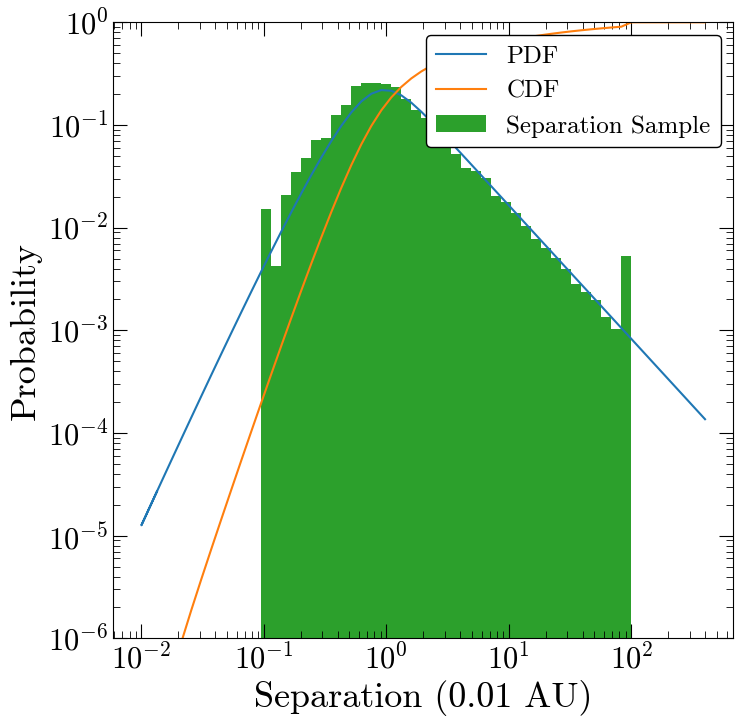

In [4]:
#show the sample
a_array,PDF,CDF,sampled_separations=separation_sample(0.55,0.55,10000)

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
ax1.plot(a_array,PDF,label='PDF')
ax1.plot(a_array,CDF,label='CDF')
ax1.hist(sampled_separations,bins=np.logspace(np.log10(0.01),np.log10(100.), 50),density=True,label='Separation Sample')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.set_ylim(10**(-6),10**(0))
ax1.set_xlabel('Separation (0.01 AU)')
ax1.set_ylabel('Probability')

# Orbital Inclination Distribution

http://www.ugastro.berkeley.edu/infrared10/adaptiveoptics/binary_orbit.pdf
- the orbital inclination is the angle between the plane of projection and the true orbital plane. Values range from 0° to 180°. For 0° ≤ i < 90° the motion is called direct. The companion then moves in the direction of increasing position angles (anticlockwise).For 90° < i ≤ 180° the motion is called retrograde.
- Moaz 2012, P(i)~sin(i)
- i is the angle between the unit normal of the orbital plane and the line of sight
    - i=0, unit normal points along line of sight
    - i=pi/2, unit normal perpendicular to line of sight and would see eclipsing system
    - i= pi, unit normal points away from line of sight

### The slight left shift in my distribution is because I am integrating from the left to get my CDF

In [5]:
#define functions to draw an inclination from a distribution given by P(i)~sin(i)

#define a function to normalize the distribution by its integral
def inclination_normalize(incl):
    def integrand_pdf(x):
        return np.sin(x)
    integral=integrate.quad(integrand_pdf, 0, np.pi)[0]
    nonnorm=np.sin(incl)
    norm=[]
    for i in range(len(nonnorm)):
        norm.append(nonnorm[i]/integral)
    return(norm,integral)

#define a function to integrate the distribution up to a given a value to get the CDF value at that point
def inclination_cdf_val(incl,endpoint):
    #get the pdf normalization factor
    pdf_norm,norm_factor=inclination_normalize(incl)
    #integrate up to a[end_point] to get the CDF at end_point
    incl=incl[:endpoint]
    def integrand_pdf(x):
        return np.sin(x)
    integral=integrate.quad(integrand_pdf, 0, incl[len(incl)-1])[0]
    return(integral/norm_factor,integral,norm_factor)

def inclination_sample(num_samples):
    incl_array=np.linspace(0,np.pi, num=50) #radians
    
    #get the PDF
    PDF=inclination_normalize(incl_array)[0]

    #calculate the CDF
    CDF=[]
    for i in range(len(incl_array)):
        val=inclination_cdf_val(incl_array,i+2)
        CDF.append(val[0])
    
    #due to numerical issues, some bines may be negative so just set these values to 0
    set_0=0
    for i in range(len(CDF)):
        if CDF[i]<0:
            CDF[i]=0
            set_0=set_0+1
    if set_0==0:
        #set the 1st entry of the CDF to 0 to ensure it covers the full 0->1 range
        CDF[0]=0
            
    #to re-create PDF, want to draw random number between 0 and 1 for CDF y-value and translate this to a separation
    #swap x and y so can get a value given random number between 0 and 1
    #interpolate
    CDF_invert=interpolate.interp1d(CDF,incl_array)
    
    #draw from the CDF to get the inclination
    y_samples=np.random.uniform(0, 1,size=num_samples)
    sampled_inclinations=CDF_invert(y_samples)
    
    return(incl_array,PDF,CDF,sampled_inclinations)
                              

Text(0, 0.5, 'Probability')

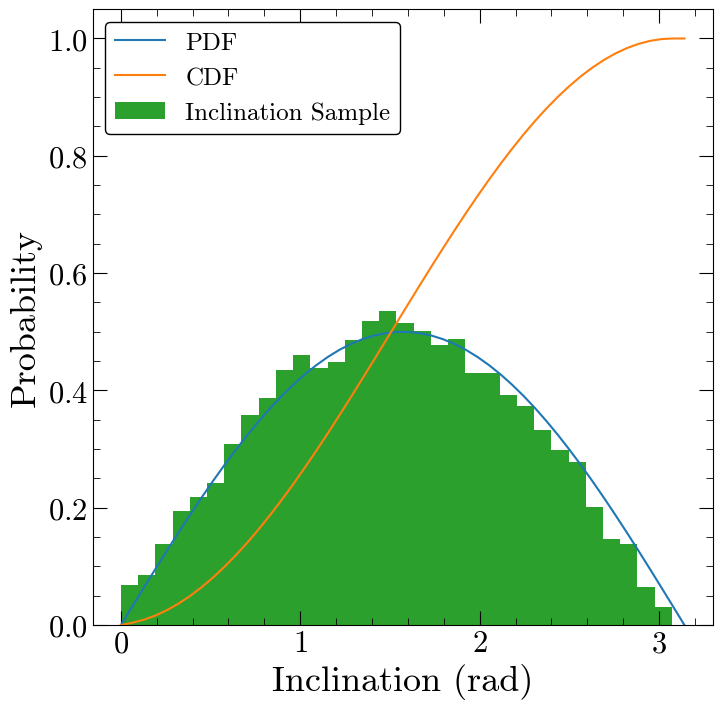

In [6]:
#show distribution
incl_array,PDF,CDF,sampled_inclinations=inclination_sample(10000)

fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
ax1.plot(incl_array,PDF,label='PDF')
ax1.plot(incl_array,CDF,label='CDF')
ax1.hist(sampled_inclinations,density=True,label='Inclination Sample')
ax1.legend()
ax1.set_xlabel('Inclination (rad)')
ax1.set_ylabel('Probability')

# Calculating radial velocity
Given orbital velocity of each component, phase, and angle of inclination.

At i=90, the normal to the plane is perpendicular to the line of sight, and you see the full orbital velocity as the RV at the RV max in the phase curve.

At i=0 or 180, the normal to the plane is parallel to the line of sight and the component of the orbital velocity along the line of sight is 0 so the RV=0

Thus, the projection of the orbital velocity along the line of sight is given by sin(i).

We will also need to choose which component has the positive/negative RV

In [7]:
primary_mass=0.6
companion_mass=1.0

primary_massCGS=primary_mass*MsunCGS
companion_massCGS=companion_mass*MsunCGS

#draw the system orbital separation from the Maoz 2018 distribution
a_array,PDF,CDF,separation=separation_sample(primary_mass,companion_mass,1)
#convert to CGS units
separation=separation*1.496*(10**11) #cm
#get the period from Kepler's law (see Maoz 2012)
period=2*np.pi*((separation**3)/(GCGS*(primary_massCGS+companion_massCGS)))**(0.5) #seconds

#assume circular orbits and get the two orbital velocties (see Maoz 2012)
primary_velocity=(2*np.pi*separation/period)*((companion_massCGS)/(primary_massCGS+companion_massCGS))
companion_velocity=(2*np.pi*separation/period)*((primary_massCGS)/(primary_massCGS+companion_massCGS))

print('separation= ',separation[0]/(1.496*(10**11)),' in 0.01 AU units')
print('period= ',period[0]/3600, ' hr')
print('primary_velocity= ',primary_velocity[0]*(10**(-5)),' km/s')
print('companion_velocity= ',companion_velocity[0]*(10**(-5)),' km/s')

separation=  8.837548919835479  in 0.01 AU units
period=  182.0506606950887  hr
primary_velocity=  79.21885297578069  km/s
companion_velocity=  47.531311785468404  km/s


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]


Text(0, 0.5, 'Apparent RV (km/s)')

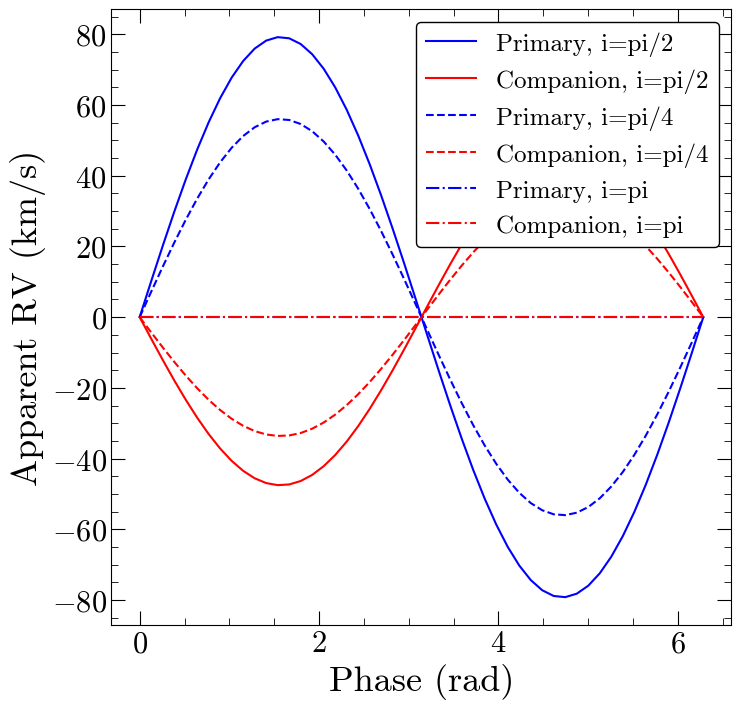

In [8]:
#get apparent radial velocity
phases=np.linspace(0,2*np.pi,50)
primary_RV=primary_velocity*np.sin(phases)*(10**(-5))
companion_RV=-companion_velocity*np.sin(phases)*(10**(-5))

#now try different inclinations
i_array=[0,np.pi/4,np.pi/2,3*np.pi/4,np.pi]

#plot the apparent RV
fig, (ax1) = plt.subplots(1, 1,figsize=(8,8))
ax1.plot(phases,primary_RV*np.sin(np.pi/2),'b',label='Primary, i=pi/2')
ax1.plot(phases,companion_RV*np.sin(np.pi/2),'r',label='Companion, i=pi/2')

ax1.plot(phases,primary_RV*np.sin(np.pi/4),'b--',label='Primary, i=pi/4')
ax1.plot(phases,companion_RV*np.sin(np.pi/4),'r--',label='Companion, i=pi/4')

ax1.plot(phases,primary_RV*np.sin(np.pi),'b-.',label='Primary, i=pi')
ax1.plot(phases,companion_RV*np.sin(np.pi),'r-.',label='Companion, i=pi')

ax1.legend()
ax1.set_xlabel('Phase (rad)')
ax1.set_ylabel('Apparent RV (km/s)')

# Import the data sets

In [9]:
#import the VAC catalog measurements with quality cuts
wd_table=pd.read_csv('csv/wd_table.csv')


/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/646736903.py:2: DtypeWarning: Columns (18,25,77,88,100,109,114,126,127,292) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_table=pd.read_csv('csv/wd_table.csv')


# Define theoretical interpolations based on the La Plata models
and various conversions between WD parameters

In [10]:
# Import the La Plata WD Models http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
la_plata_mass=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('Software/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
logg_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=loggs_long, interp_type='linear')     


In [11]:
def m_from_vg_r(vg, r):
    #take vg in km/s and r in Rsun and get M in Msun
    M=(vg*(10**5)*r*RsunCGS*cCGS/GCGS)/MsunCGS
    return(M)
  
def m_from_vg_logg(vg, logg):
    #take vg in km/s and logg in CGS units and get M in Msun
    vg2=(vg*10**5)**2
    c2=cCGS**2
    g=10**logg
    M=((vg2*c2)/(GCGS*g))/MsunCGS
    return(M)

def vg_from_r_teff(radius_array, teff_array):
    #this function takes in an array of radii in solar units and temperatures in K
    #returns the predicted gravitational redshift in km/s from a model
    
    #WD mass in CGS units
    mass_wd = mass_from_radius_teff(radius_array, teff_array)* MsunCGS
    
    #gravitational redshift in km/s
    rv = (GCGS * mass_wd / (cCGS * radius_array*RsunCGS))*10**(-5)

    return rv

def vg_from_logg_teff(logg_array, teff_array):
    #this function takes in an array of loggs in CGS units and temperatures in K
    #returns the predicted gravitational redshift in km/s from a Fontaine Model
    
    mass_wd = mass_from_logg_teff(logg_array, teff_array)* MsunCGS
    
    #gravitational redshift in km/s
    rv = np.sqrt(mass_wd*GCGS*(10**logg_array)/cCGS**2)*10**(-5)

    return rv

def vg_from_m_teff(massarray, teff):
    #given the mass and teff, get the grav redshift
    massarray = np.asarray(massarray)
    teffarray = np.repeat(teff, len(massarray))
    
    #get radius from m and teff
    rsun = radius_from_mass_teff(massarray,teffarray)
    
    radius = rsun * radius_sun
    mass = massarray * mass_sun
    
    #get grav redshift in SI units
    vg = newton_G * mass / (speed_light * radius)

    return vg*1e-3 #convert to km/s

# Get the properties of the sample with binaries
We want to build a distribution showing how binaries impact measured parameters, so for now assume EVERY WD is in a binary. In the next notebook, we will use the literature on the proportion of WDs in binaries to select which objects are binaries when adding binary contamination.

In [12]:
def get_no_binary_sample(table, sample_size, plot=True):
    #this function draws a mass sample from our VAC radius+theory distribution
    #and a teff sample from our measured photometric temperatures
    #using the La Plata models, the radii and loggs of these samples are computed
    
    draw_size=int(1.5*sample_size)

    #draw masses
    all_measured_masses=table['mass_rad_theory']
    mass_sample = np.random.choice(all_measured_masses, size = draw_size, replace = True)
        
    #exclude any WDs more massive than 1.2 Msun or less massive than 0.2 Msun
    out = (mass_sample > 1.2) + (mass_sample < 0.2)
    mass_sample = mass_sample[~out]
    
    #draw a random sample of temperatures from those measured in the table
    all_measured_teffs=table['teff_phot']
    teff_sample = np.random.choice(all_measured_teffs, size = len(mass_sample), replace = True)
    
    #for given mass and teff samples, get the radii sample
    radius_sample = radius_from_mass_teff(mass_sample, teff_sample)
    #mask any nan samples or WDs with radii>0.029 (these are ELMs)
    out = np.isnan(radius_sample) + (radius_sample > 0.029)
    mass_sample = mass_sample[~out]
    radius_sample = radius_sample[~out]
    teff_sample = teff_sample[~out]
    
    #for given mass and teff samples, get the logg sample
    logg_sample = logg_from_mass_teff(mass_sample, teff_sample)
    #mask any nan samples or WDs with logg<7 (these are ELMs)
    out = np.isnan(logg_sample) + (logg_sample < 7)
    mass_sample = mass_sample[~out]
    radius_sample = radius_sample[~out]
    teff_sample = teff_sample[~out]
    logg_sample = logg_sample[~out]
    
    #get gravitational redshifts of sample
    vg_sample = vg_from_r_teff(radius_sample, teff_sample)
    
    simulated_wds=pd.DataFrame()
    #record these primary parameters
    simulated_wds['primary_mass']=mass_sample
    simulated_wds['primary_teff']=teff_sample
    simulated_wds['primary_radius']=radius_sample
    simulated_wds['primary_logg']=logg_sample
    simulated_wds['primary_vg']=vg_sample

    #reduce down to the desired sample size
    simulated_wds= simulated_wds.sample(n=sample_size,replace=False)
    #reset the indices
    indices=np.arange(0,len(simulated_wds))
    simulated_wds.set_index(indices,inplace=True)
    
    if plot==True:
        #plot the samples
        fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5,figsize=(25,5))
        ax1.hist(simulated_wds['primary_mass'], density=True, bins='auto', histtype='stepfilled')
        ax1.axvline(x = 0.6, color = 'r')
        ax1.set_xlim([0,1.3])
        ax1.set_xlabel('Mass Sample (Msun)')
        
        ax2.hist(simulated_wds['primary_teff'], density=True, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('Teff Sample (K)')
        
        ax3.hist(simulated_wds['primary_radius'], density=True, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('Radius Sample\n(Rsun)')
        
        ax4.hist(simulated_wds['primary_logg'], density=True, bins='auto', histtype='stepfilled')
        ax4.set_xlabel('Logg Sample\n(dex)')
        
        ax5.hist(simulated_wds['primary_vg'], density=True, bins='auto', histtype='stepfilled')
        ax5.set_xlabel('Grav Redshift\nSample (km/s)')
        
        plt.subplots_adjust(wspace = 0.3,hspace=0.4)

        plt.show()
        
    return(simulated_wds)


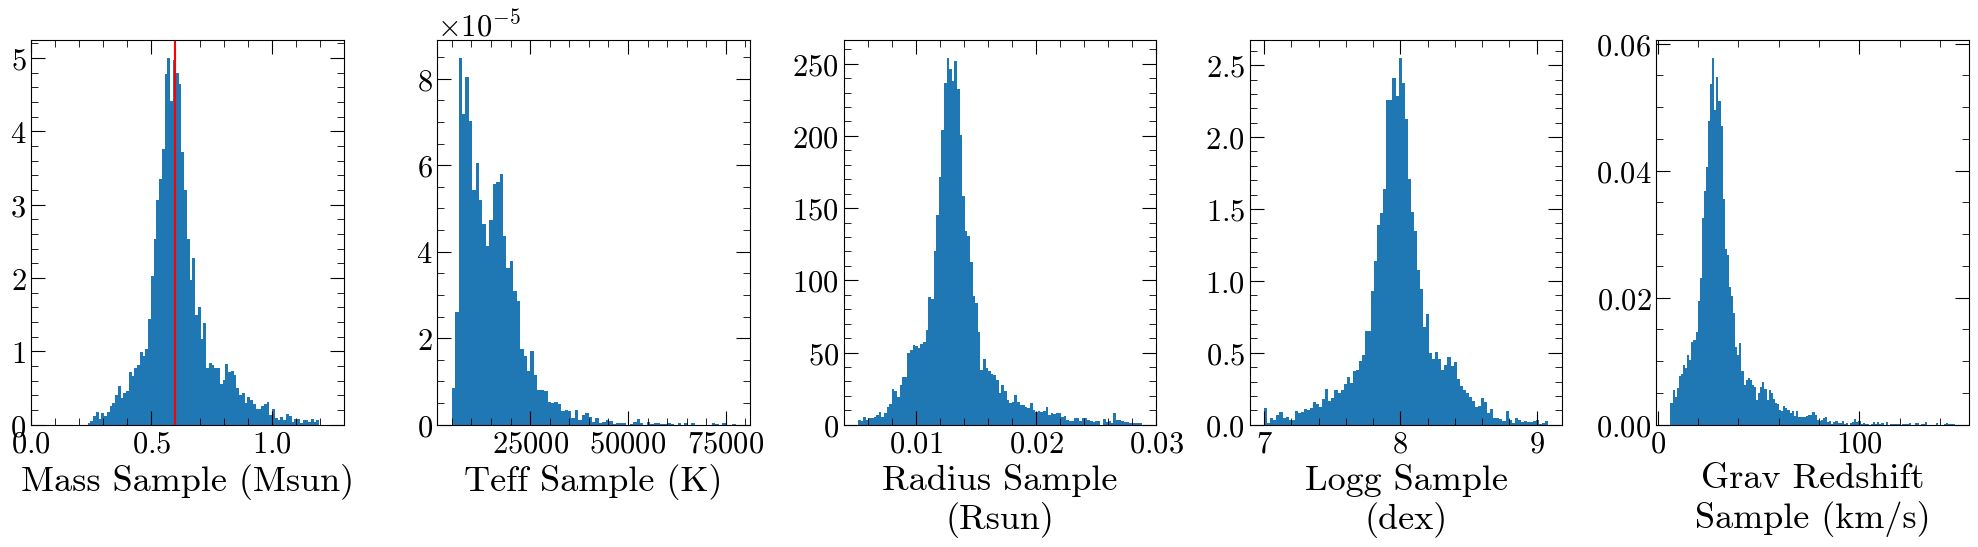

In [13]:
sample_size=10000
simulated_wds=get_no_binary_sample(wd_table, sample_size,plot=True)

In [16]:
def get_binary_sample(simulated_wds,plot=False):
    mass_sample=simulated_wds['primary_mass']
    teff_sample=simulated_wds['primary_teff']
    radius_sample=simulated_wds['primary_radius']
    logg_sample=simulated_wds['primary_logg']
    vg_sample=simulated_wds['primary_vg']
    
    companion_masss=[]
    companion_teffs=[]
    companion_radiuss=[]
    companion_loggs=[]
    companion_vgs=[]
    
    separations=[]
    periods=[]
    primary_velocitys=[]
    companion_velocitys=[]
    inclinations=[]
    phases=[]
    
    primary_RVs=[]
    companion_RVs=[]
        
    for i in tqdm(range(len(mass_sample))):
        primary_mass=mass_sample[i]
        primary_massCGS=primary_mass*MsunCGS
        primary_teff=teff_sample[i]
        primary_radius=radius_sample[i]
        primary_logg=logg_sample[i]
        primary_vg=vg_sample[i]
        
        #set it so all WDs have a companion to get a sense of how binaries affect the distribution of parameters
        companion=True

        #if the WD has a companion, draw the properties of the companion
        if companion==True:
            #draw mass from mass_sample, requiring companion mass>primary mass
            #more massive WD = smaller= will be subdominant secondary in system
            companion_mass=0
            while companion_mass < primary_mass:
                companion_mass=np.random.choice(mass_sample)
            companion_massCGS=companion_mass*MsunCGS
            #draw teff from teff_sample
            companion_teff=np.random.choice(teff_sample)
            #get companion radius, logg, and vg
            companion_radius = radius_from_mass_teff(companion_mass, primary_teff)
            companion_logg = logg_from_mass_teff(companion_mass, primary_teff)
            companion_vg = vg_from_r_teff(companion_radius, primary_teff)
            #draw the system orbital separation from the Maoz 2018 distribution
            a_array,PDF,CDF,separation=separation_sample(primary_mass,companion_mass,1)
            #convert to CGS units
            separation=separation[0]*1.496*(10**11) #cm
            #get the period from Kepler's law (see Maoz 2012)
            period=2*np.pi*((separation**3)/(GCGS*(primary_massCGS+companion_massCGS)))**(0.5) #seconds
            #assume circular orbits and get the two orbital velocties (see Maoz 2012)
            primary_velocity=(2*np.pi*separation/period)*((companion_massCGS)/(primary_massCGS+companion_massCGS))
            companion_velocity=(2*np.pi*separation/period)*((primary_massCGS)/(primary_massCGS+companion_massCGS))
            #draw the line-of-sight inclination from P(i)~sin(i) (see Maoz 2012)
            incl_array,PDF,CDF,inclination=inclination_sample(1)
            inclination=inclination[0]
            #choose a random orbital phase, 0->2pi
            phase=np.random.uniform(0,2*np.pi)
            #randomly choose which component has positive RV
            sign=random.randint(0, 1)
            if sign==0:
                primary_velocity=-1*primary_velocity
            if sign==1:
                companion_velocity=-1*companion_velocity
            #calculate the orbital RVs
            primary_RV=primary_velocity*np.sin(phase)*np.sin(inclination)
            companion_RV=companion_velocity*np.sin(phase)*np.sin(inclination)
        else:
            companion_mass=np.nan
            companion_teff=np.nan
            companion_radius = np.nan
            companion_logg = np.nan
            companion_vg = np.nan
            separation = np.nan
            period = np.nan
            primary_velocity = np.nan
            companion_velocity = np.nan
            inclination = np.nan
            phase = np.nan
            primary_RV= np.nan
            companion_RV= np.nan
        companion_masss.append(companion_mass)
        companion_teffs.append(companion_teff)
        companion_radiuss.append(companion_radius)
        companion_loggs.append(companion_logg)
        companion_vgs.append(companion_vg)
        separations.append(separation)
        periods.append(period)
        primary_velocitys.append(primary_velocity)
        companion_velocitys.append(companion_velocity)
        inclinations.append(inclination)
        phases.append(phase)
        primary_RVs.append(primary_RV)
        companion_RVs.append(companion_RV)
    
    simulated_wds['companion_mass']=companion_masss
    simulated_wds['companion_teff']=companion_teffs
    simulated_wds['companion_radius']=companion_radiuss
    simulated_wds['companion_logg']=companion_loggs
    simulated_wds['companion_vg']=companion_vgs
    simulated_wds['separation']=separations
    simulated_wds['period']=periods
    simulated_wds['primary_velocity']=primary_velocitys
    simulated_wds['companion_velocity']=companion_velocitys
    simulated_wds['inclination']=inclinations
    simulated_wds['phase']=phases
    simulated_wds['primary_rv']=primary_RVs
    simulated_wds['companion_rv']=companion_RVs
    
    if plot==True:
        #plot the samples
        fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16))= plt.subplots(4, 4,figsize=(25,25))
        
        ax1.hist(companion_masss, density=True, bins='auto', histtype='stepfilled')
        ax1.set_xlabel('Companion Mass (Msun)')
        
        ax2.hist(companion_teffs, density=True, bins='auto', histtype='stepfilled')
        ax2.set_xlabel('Companion Teff (K)')
        
        ax3.hist(companion_radiuss, density=True, bins='auto', histtype='stepfilled')
        ax3.set_xlabel('Companion Radius (Rsun)')
        
        ax4.hist(companion_loggs, density=True, bins='auto', histtype='stepfilled')
        ax4.set_xlabel('Companion Logg (dex)')
        
        ax5.hist(companion_vgs, density=True, bins='auto', histtype='stepfilled')
        ax5.set_xlabel('Companion Vg (km/s)')
        
        ax6.hist(np.array(separations)/(1.496*(10**11)), density=True, bins='auto', histtype='stepfilled')
        ax6.set_xlabel('System Separation (0.01 AU)')
        
        ax7.hist(np.array(periods)/3600, density=True, bins='auto', histtype='stepfilled')
        ax7.set_xlabel('System Period (hr)')
        
        ax8.hist(np.array(primary_velocitys)*(10**(-5)), density=True, bins='auto', histtype='stepfilled')
        ax8.set_xlabel('Primary Orbital Velocity (km/s)')
        
        ax9.hist(np.array(companion_velocitys)*(10**(-5)), density=True, bins='auto', histtype='stepfilled')
        ax9.set_xlabel('Companion Orbital Velocity (km/s)')
        
        ax10.hist(inclinations, density=True, bins='auto', histtype='stepfilled')
        ax10.set_xlabel('System Inclination (rad)')
        
        ax11.hist(phases, density=True, bins='auto', histtype='stepfilled')
        ax11.set_xlabel('System Phase')
        
        ax12.hist(np.array(primary_RVs)*(10**(-5)), density=True, bins='auto', histtype='stepfilled')
        ax12.set_xlabel('Primary Radial Velocity (km/s)')
        
        ax13.hist(np.array(companion_RVs)*(10**(-5)), density=True, bins='auto', histtype='stepfilled')
        ax13.set_xlabel('Companion Radial Velocity (km/s)')

        plt.show()
        
    return(simulated_wds)


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:36: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral=integrate.quad(integrand_pdf, a[0], a[len(a)-1])[0]
  8%|███▎                                   | 836/10000 [00:35<06:23, 23.91it/s]/var/folders/ny/bjybyvhj6s9_2ms5cmld1xbc0000gn/T/ipykernel_90657/1549475591.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is 

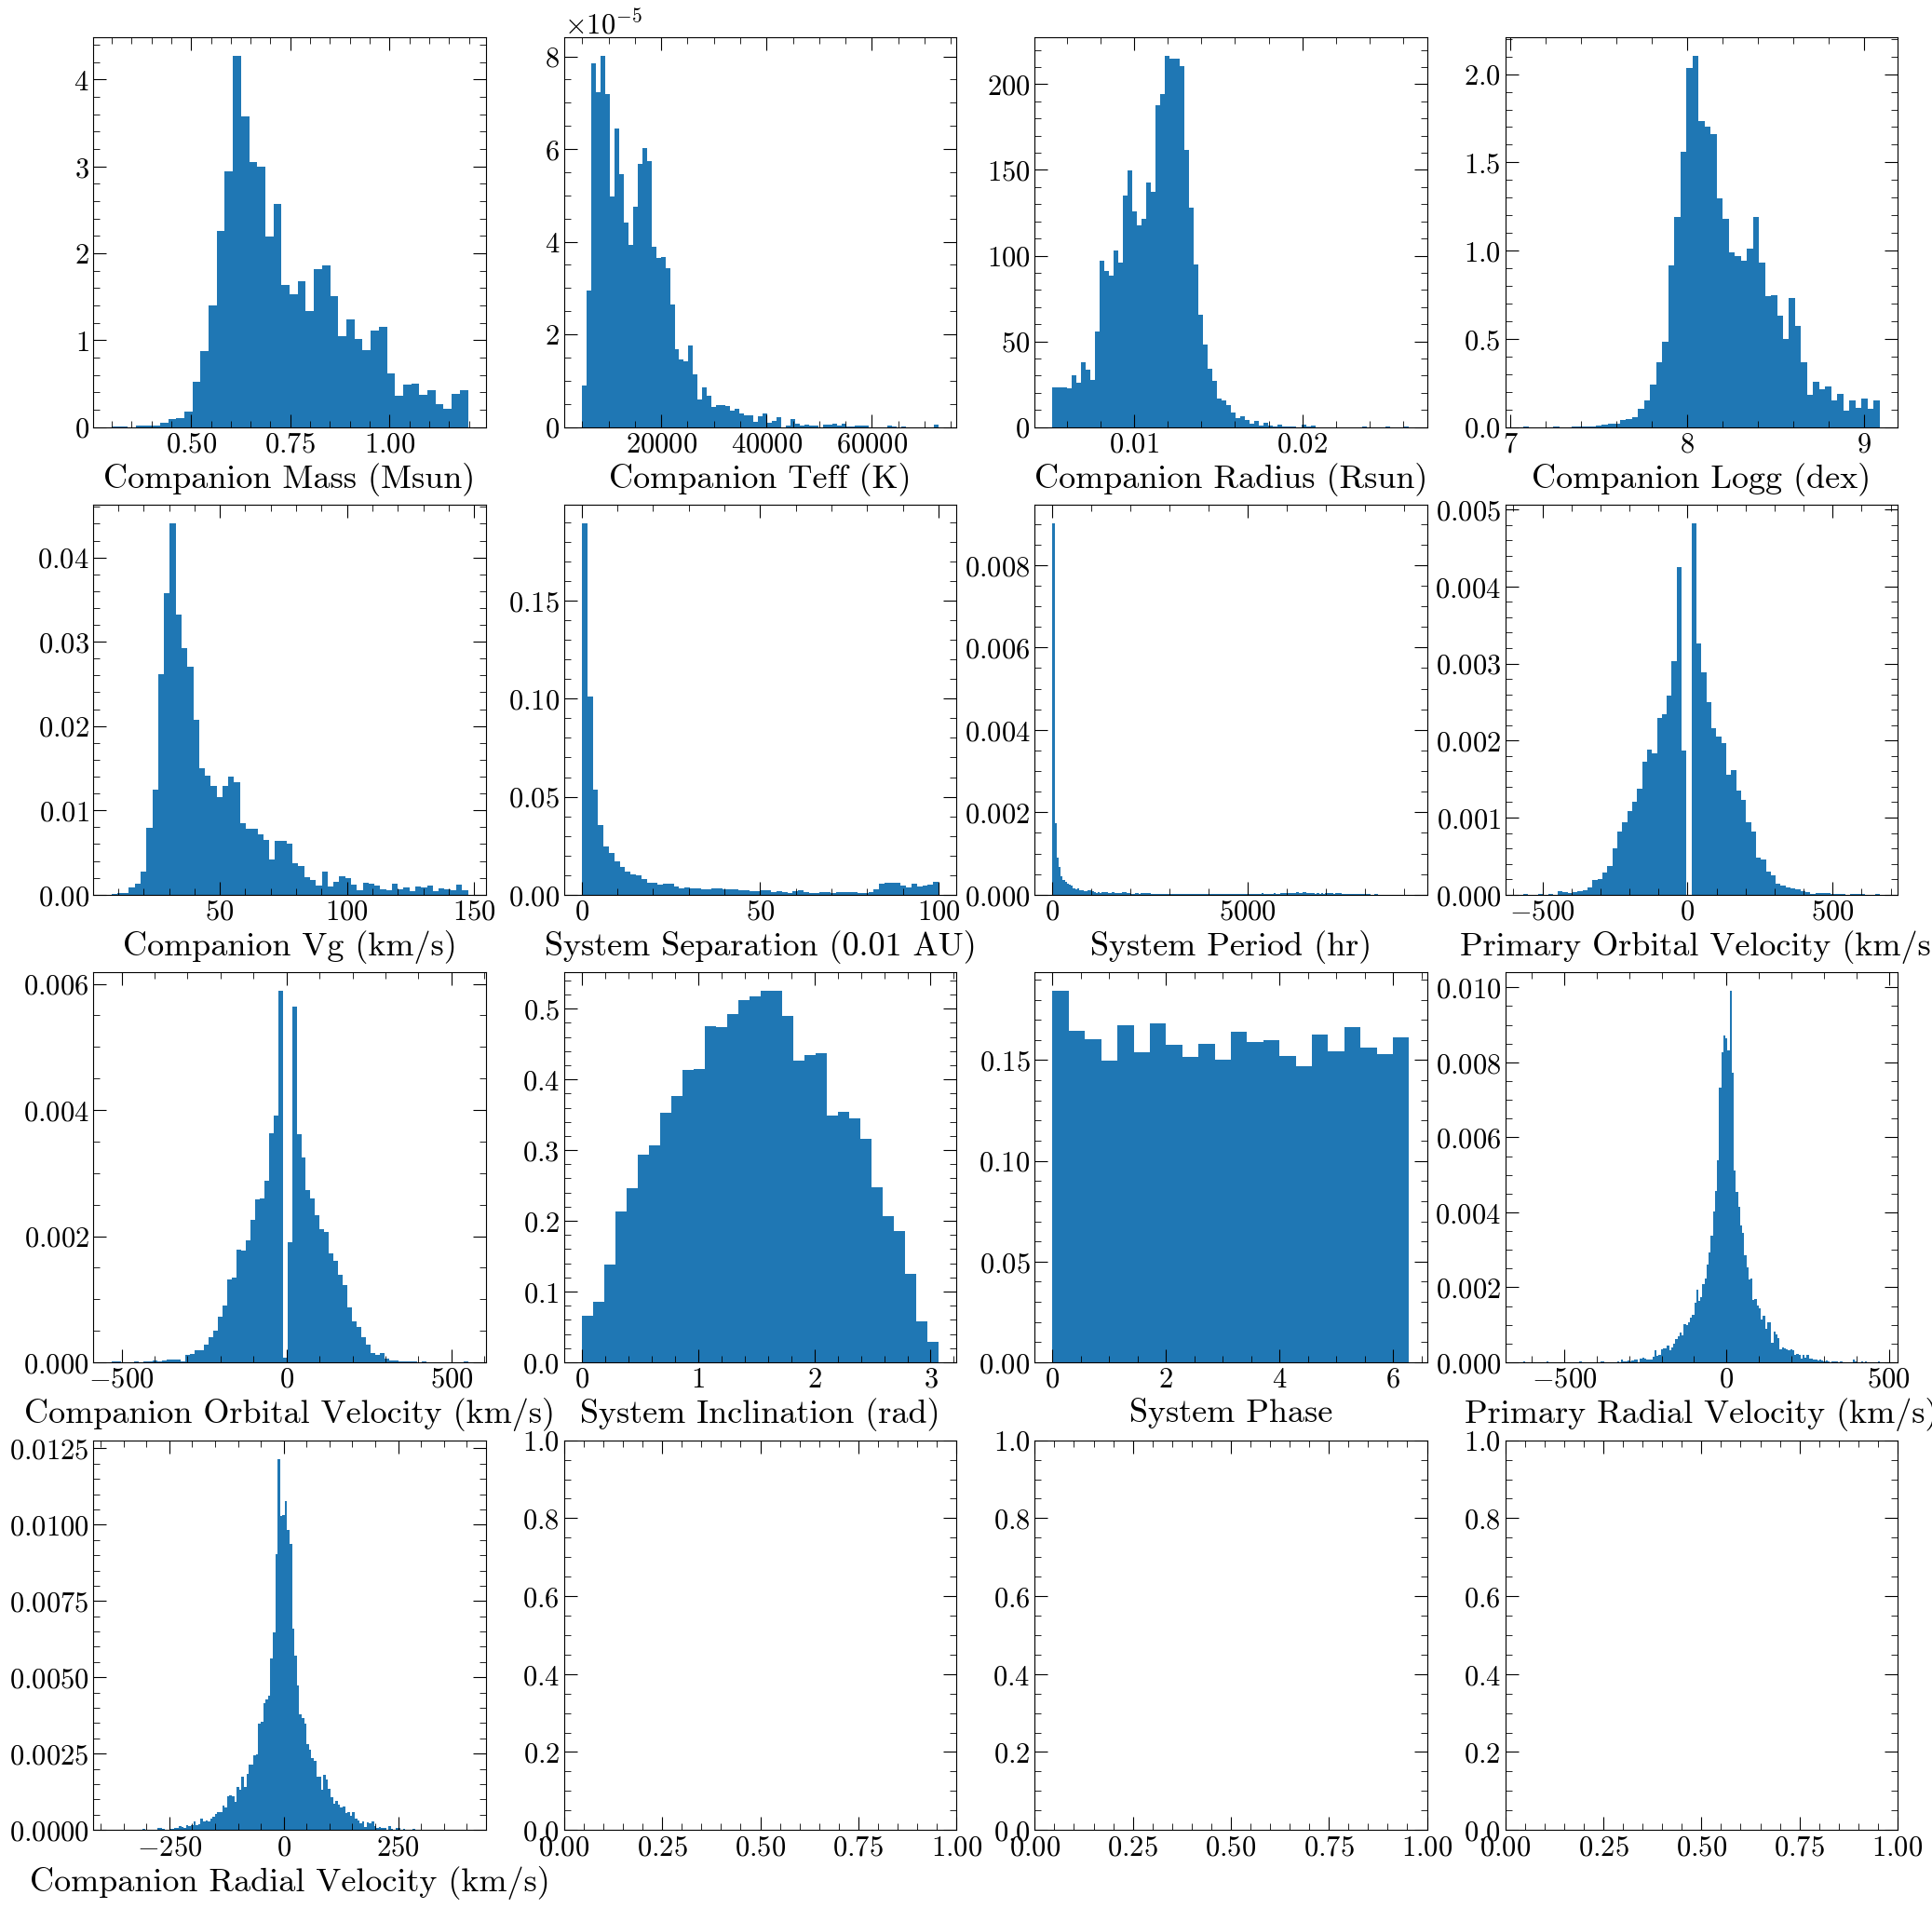

In [17]:
simulated_wds=get_binary_sample(simulated_wds,plot=True)

In [18]:
#save as a .csv
#simulated_wds.to_csv('csv/binaries_effect_phot_sample.csv',index=False)


In [19]:
#read back in
simulated_wds=pd.read_csv('csv/binaries_effect_phot_sample.csv')

# Measure the impact of binarity on the photometric parameters for SDSS and Gaia photometry

### Define the Radius/Teff fitting functions

In [20]:
def air2vac(wv):
    _tl=1.e4/np.array(wv)
    return (np.array(wv)*(1.+6.4328e-5+2.94981e-2/\
                          (146.-_tl**2)+2.5540e-4/(41.-_tl**2)))

In [21]:
modpath_m='models/montreal_da'
base_wavl, montreal_model, montreal_model_low_logg, table = build_montreal_da(modpath_m,flux_unit = 'flam')


In [22]:
def mag_to_flux_spec_Vega(mag, filt, e_mag = None):
    #convert from magntiudes on the Vega system to flux for a particular filter
    #Gaia magnitudes are on the Vega system
    if e_mag is not None:
        #compute the flux error given the error on the magnitude
        #assume the error on the zero point is negligible
        return (10**(-0.4*(mag + filt.Vega_zero_mag)), np.abs((np.log(10)*(-0.4)*10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)))
    else:
        return 10**(-0.4*(mag + filt.Vega_zero_mag))
    
def mag_to_flux_spec_AB(mag, filt, e_mag = None):
    #convert from magntiudes on the AB system to flux for a particular filter
    #SDSS magnitudes are on the AB system
    if e_mag is not None:
        #compute the flux error given the error on the magnitude
        #assume the error on the zero point is negligible
        return (10**(-0.4*(mag + filt.AB_zero_mag)), np.abs((np.log(10)*(-0.4)*10**(-0.4 * (mag + filt.AB_zero_mag)) * e_mag)))
    else:
        return 10**(-0.4*(mag + filt.AB_zero_mag))
    
def template(teff, logg, radius, distance):
    #get montreal model flux spectrum for a WD with a given radius, located a given distance away
    
    fl= 4*np.pi*montreal_model((teff,logg))#flux in physical units
    
    #convert to SI units
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
    
    fl = (radius / distance)**2 * fl
    return fl
    

def get_model_flux_sdss(params):
    #get model photometric flux for a WD with a given radius, located a given distance away
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([sdss_filters[i].get_flux(base_wavl * pyphot.unit['angstrom'], fl * pyphot.unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(sdss_filters))])
    return flux

def get_model_flux_gaia(params):
    #get model photometric flux for a WD with a given radius, located a given distance away
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    fl = template(teff, logg, radius, distance) 
            
    flux = np.array([gaia_filters[i].get_flux(base_wavl * pyphot.unit['angstrom'], fl * pyphot.unit['erg/s/cm**2/angstrom'], axis = 1).to('erg/s/cm**2/angstrom').value for i in range(len(gaia_filters))])
    return flux
    

def residual_sdss(params, obs_flux = None, e_obs_flux = None):
    #calculate the chi2 between the model and the fit
    model_flux = get_model_flux_sdss(params)
    
    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2

    return chisquare

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    #calculate the chi2 between the model and the fit
    model_flux = get_model_flux_gaia(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2

    return chisquare

def get_parameters_sdss(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, 100]):          
    #use lmfit.minimize to fit the model to the data
    params = lmfit.Parameters()
    params.add('teff', value = p0[0], min = 1501, max = 129999, vary = True)
    params.add('logg', value = p0[1], min=7, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 20000, vary = False)
            
    result = lmfit.minimize(residual_sdss, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
        
    return result

def get_parameters_gaia(obs_flux, e_obs_flux, vary_logg=False, p0 = [10000, 8, 0.003, 100]):          
    #use lmfit.minimize to fit the model to the data
    params = lmfit.Parameters()
    params.add('teff', value = p0[0], min = 1501, max = 129999, vary = True)
    params.add('logg', value = p0[1], min=7, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.000001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 20000, vary = False)
            
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
        
    return result

In [23]:
# Use pyphot to get the SDSS and Gaia photometric band wavelengths we want to fit
lib = pyphot.get_library()
sdss_filters = [lib['SDSS_u'],lib['SDSS_r'],lib['SDSS_z']]
sdss_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in sdss_filters])
gaia_filters = [lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([x.lpivot.to('angstrom').value for x in gaia_filters])

### For SDSS photometry

In [24]:
#define functions to get the absolute magnitude in SDSS bands of the WD given the mass and teff
font_model_u = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Fontaine2001',
                             high_mass_model='Fontaine2001',
                             atm_type='H', HR_bands=('Sg-Sr', 'Su'))
font_model_r = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Fontaine2001',
                             high_mass_model='Fontaine2001',
                             atm_type='H', HR_bands=('Sg-Sr', 'Sr'))
font_model_z = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Fontaine2001',
                             high_mass_model='Fontaine2001',
                             atm_type='H', HR_bands=('Sg-Sr', 'Sz'))
m_teff_to_uMag = WD_models.interp_xy_z_func(x=font_model_u['mass_array'],
                                                      y=10**font_model_u['logteff'],
                                                      z=font_model_u['Mag'],
                                                      interp_type='linear')
m_teff_to_rMag = WD_models.interp_xy_z_func(x=font_model_r['mass_array'],
                                                      y=10**font_model_r['logteff'],
                                                      z=font_model_r['Mag'],
                                                      interp_type='linear')
m_teff_to_zMag = WD_models.interp_xy_z_func(x=font_model_z['mass_array'],
                                                      y=10**font_model_z['logteff'],
                                                      z=font_model_z['Mag'],
                                                      interp_type='linear')
#get the mean SDSS photometric errors, use these as the basis for errors in fitting the photometry
#divide by factor of 10
mean_uerr=np.mean(wd_table['magerr_ab_u'])/10
mean_rerr=np.mean(wd_table['magerr_ab_r'])/10
mean_zerr=np.mean(wd_table['magerr_ab_z'])/10

def fit_binary_SDSSphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss,plot=False):
    combined_radiuss=[]
    e_combined_radiuss=[]
    combined_teffs=[]
    e_combined_teffs=[]
    for i in tqdm(range(len(primary_masss))):
        primary_mass=primary_masss[i]
        primary_teff=primary_teffs[i]
        primary_radius=primary_radiuss[i]
        companion_mass=companion_masss[i]
        companion_teff=companion_teffs[i]
        companion_radius=companion_radiuss[i]
        if companion_mass>0:
            try:
                #Use wdmodels to get the SDSS u+r+z absolute magnitudes for the primary and secondary
                primary_uMag=m_teff_to_uMag(primary_mass,primary_teff)
                primary_rMag=m_teff_to_rMag(primary_mass,primary_teff)
                primary_zMag=m_teff_to_zMag(primary_mass,primary_teff)
                companion_uMag=m_teff_to_uMag(companion_mass,companion_teff)
                companion_rMag=m_teff_to_rMag(companion_mass,companion_teff)
                companion_zMag=m_teff_to_zMag(companion_mass,companion_teff)
                #Combine the primary and companion magnitudes to get the total asolute magnitude for the system
                #assume all binaries are blended regardless of separation
                combined_uMag= -2.5 * np.log10(10**(-primary_uMag*0.4)+ 10**(-companion_uMag*0.4))
                combined_rMag= -2.5 * np.log10(10**(-primary_rMag*0.4)+ 10**(-companion_rMag*0.4))
                combined_zMag= -2.5 * np.log10(10**(-primary_zMag*0.4)+ 10**(-companion_zMag*0.4))
                #re-fit the photometric radius/temperature for just the binaries given the new photometry
                #and a distance of 10 pc
                #convert extinction-corrected SDSS magnitude to flux in erg/s/cm^2/AA
                obs_flux_u, e_obs_flux_u = mag_to_flux_spec_AB(combined_uMag,sdss_filters[0],mean_uerr)
                obs_flux_r, e_obs_flux_r = mag_to_flux_spec_AB(combined_rMag,sdss_filters[1],mean_rerr)
                obs_flux_z, e_obs_flux_z = mag_to_flux_spec_AB(combined_zMag,sdss_filters[2],mean_zerr)
                obs_flux=np.array([obs_flux_u,obs_flux_r,obs_flux_z])
                e_obs_flux=np.array([e_obs_flux_u,e_obs_flux_r,e_obs_flux_z])

                #fit for logg=8
                distance=10 #pc
                sdss_logg8 = get_parameters_sdss(obs_flux,e_obs_flux,p0 = [10000, 8, 0.003, distance])

                #record the fit results
                #radius in solar units
                combined_radiuss.append(sdss_logg8.params['radius'].value)
                #error on the radius is stderr in measured radius and the absolute value of the difference in the logg=7,9 radius results added in quadrature
                e_combined_radiuss.append(sdss_logg8.params['radius'].stderr)
                #photometric temperature in K
                combined_teffs.append(sdss_logg8.params['teff'].value)
                #error on photometric temperature in K
                e_combined_teffs.append(sdss_logg8.params['teff'].stderr)

                if plot==True:
                    # plot the model spectrum, model photometric flux, and observed photometric flux
                    # with the fit results
                    fig, ax1 =plt.subplots(1,1,figsize=(7,7))
                    ax1.errorbar([sdss_filters[j].lpivot.to('angstrom').value for j in range(len(sdss_filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
                    ax1.plot([sdss_filters[j].lpivot.to('angstrom').value for j in range(len(sdss_filters))], get_model_flux_sdss(sdss_logg8.params), 'co', markersize = 10, label = 'Model SED')

                    model_fl = template(sdss_logg8.params['teff'].value, sdss_logg8.params['logg'].value, sdss_logg8.params['radius'].value, sdss_logg8.params['distance'].value)
                    mask = (3600 < base_wavl)*(base_wavl<9000)
                    ax1.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')

                    ax1.text(0.5, 0.70,  "$T_{eff}$" + " = {:2.6} $K$".format(sdss_logg8.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.65, "$\log g$" + " = {:2.5f}".format(sdss_logg8.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.60, r'$Radius = ${:2.5f} $R_\odot$'.format(sdss_logg8.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.55, '$Distance = ${:2.1f} $pc$'.format(sdss_logg8.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
                    ax1.text(0.5, 0.50, r'$\chi_r^2 = ${:2.2f}'.format(sdss_logg8.redchi), transform = plt.gca().transAxes, fontsize = 18)

                    ax1.set_xlim((3450, 9000))
                    ax1.set_xlabel(r'Wavelength $[\AA]$')
                    ax1.set_ylabel('Flux $[erg/s/cm^2/\AA]$')
                    ax1.set_title('SDSS u+r+z Photometric Fit')
                    ax1.legend()
                    plt.show()
            except:
                combined_radiuss.append(np.nan)
                e_combined_radiuss.append(np.nan)
                combined_teffs.append(np.nan)
                e_combined_teffs.append(np.nan) 
        else:
            combined_radiuss.append(primary_radius)
            e_combined_radiuss.append(np.nan)
            combined_teffs.append(primary_teff)
            e_combined_teffs.append(np.nan)
    return(combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs)

### For Gaia photometry

In [25]:
#define functions to get the absolute magnitude in Gaia bands of the WD given the mass and teff
font_model_bp = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Fontaine2001',
                             high_mass_model='Fontaine2001',
                             atm_type='H', HR_bands=('bp-rp', 'bp'))
font_model_rp = WD_models.load_model(low_mass_model='Fontaine2001',
                             middle_mass_model='Fontaine2001',
                             high_mass_model='Fontaine2001',
                             atm_type='H', HR_bands=('bp-rp', 'rp'))

m_teff_to_bpMag = WD_models.interp_xy_z_func(x=font_model_bp['mass_array'],
                                                      y=10**font_model_bp['logteff'],
                                                      z=font_model_bp['Mag'],
                                                      interp_type='linear')
m_teff_to_rpMag = WD_models.interp_xy_z_func(x=font_model_rp['mass_array'],
                                                      y=10**font_model_rp['logteff'],
                                                      z=font_model_rp['Mag'],
                                                      interp_type='linear')

#get the mean Gaia photometric errors, use these as the basis for errors in fitting the photometry
mean_bperr=np.mean(wd_table['phot_bp_mean_flux_error'])
mean_rperr=np.mean(wd_table['phot_rp_mean_flux_error'])

def fit_binary_Gaiaphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss,plot=False):
    combined_radiuss=[]
    e_combined_radiuss=[]
    combined_teffs=[]
    e_combined_teffs=[]
    for i in tqdm(range(len(primary_masss))):
        primary_mass=primary_masss[i]
        primary_teff=primary_teffs[i]
        primary_radius=primary_radiuss[i]
        companion_mass=companion_masss[i]
        companion_teff=companion_teffs[i]
        companion_radius=companion_radiuss[i]
        if companion_mass>0:
            try:
                #Use wdmodels to get the Gaia BP+RP absolute magnitudes for the primary and secondary
                primary_bpMag=m_teff_to_bpMag(primary_mass,primary_teff)
                primary_rpMag=m_teff_to_rpMag(primary_mass,primary_teff)
                companion_bpMag=m_teff_to_bpMag(companion_mass,companion_teff)
                companion_rpMag=m_teff_to_rpMag(companion_mass,companion_teff)
                #Combine the primary and companion magnitudes to get the total asolute magnitude for the system
                #assume all binaries are blended regardless of separation
                combined_bpMag= -2.5 * np.log10(10**(-primary_bpMag*0.4)+ 10**(-companion_bpMag*0.4))
                combined_rpMag= -2.5 * np.log10(10**(-primary_rpMag*0.4)+ 10**(-companion_rpMag*0.4))
                #re-fit the photometric radius/temperature for just the binaries given the new photometry
                #and a distance of 10 pc
                #convert extinction-corrected Gaia magnitude to flux in erg/s/cm^2/AA
                obs_flux = np.array([mag_to_flux_spec_Vega(combined_bpMag, gaia_filters[0]),
                                     mag_to_flux_spec_Vega(combined_rpMag, gaia_filters[1])])
                #convert Gaia flux errors (electron/s) to erg/s/cm^2/AA
                e_obs_flux = np.array([mean_bperr * 3.009167e-21 *100, mean_rperr * 1.638483e-21 *100 ])

                #fit for logg=8
                distance=10 #pc
                gaia_logg8 = get_parameters_gaia(obs_flux,e_obs_flux,p0 = [10000, 8, 0.003, distance])

                #record the fit results
                #radius in solar units
                combined_radiuss.append(gaia_logg8.params['radius'].value)
                #error on the radius is stderr in measured radius and the absolute value of the difference in the logg=7,9 radius results added in quadrature
                e_combined_radiuss.append(gaia_logg8.params['radius'].stderr)
                #photometric temperature in K
                combined_teffs.append(gaia_logg8.params['teff'].value)
                #error on photometric temperature in K
                e_combined_teffs.append(gaia_logg8.params['teff'].stderr)

                if plot==True:
                    # plot the model spectrum, model photometric flux, and observed photometric flux
                    # with the fit results
                    fig, ax1 =plt.subplots(1,1,figsize=(7,7))
                    ax1.errorbar([gaia_filters[j].lpivot.to('angstrom').value for j in range(len(gaia_filters))], obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED', zorder = 10)
                    ax1.plot([gaia_filters[j].lpivot.to('angstrom').value for j in range(len(gaia_filters))], get_model_flux_gaia(gaia_logg8.params), 'co', markersize = 10, label = 'Model SED')

                    model_fl = template(gaia_logg8.params['teff'].value, gaia_logg8.params['logg'].value, gaia_logg8.params['radius'].value, gaia_logg8.params['distance'].value)
                    mask = (3600 < base_wavl)*(base_wavl<9000)
                    ax1.plot(base_wavl[mask], model_fl[mask], c = 'k', label = 'Model Spectrum')

                    ax1.text(0.5, 0.70, "$T_{eff}$" + " = {:2.6} $K$".format(gaia_logg8.params['teff'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.65, "$\log g$" + " = {:2.5f}".format(gaia_logg8.params['logg'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.60, r'$Radius = ${:2.5f} $R_\odot$'.format(gaia_logg8.params['radius'].value), transform = plt.gca().transAxes, fontsize = 18)
                    ax1.text(0.5, 0.55, '$Distance = ${:2.1f} $pc$'.format(gaia_logg8.params['distance'].value), transform = plt.gca().transAxes, fontsize=18)
                    ax1.text(0.5, 0.50, r'$\chi_r^2 = ${:2.2f}'.format(gaia_logg8.redchi), transform = plt.gca().transAxes, fontsize = 18)

                    ax1.set_xlim((3450, 9000))
                    ax1.set_xlabel(r'Wavelength $[\AA]$')
                    ax1.set_ylabel('Flux $[erg/s/cm^2/\AA]$')
                    ax1.set_title('Gaia BP+RP Photometric Fit')
                    ax1.legend()
                    plt.show()
            except:
                combined_radiuss.append(np.nan)
                e_combined_radiuss.append(np.nan)
                combined_teffs.append(np.nan)
                e_combined_teffs.append(np.nan) 
        else:
            combined_radiuss.append(primary_radius)
            e_combined_radiuss.append(np.nan)
            combined_teffs.append(primary_teff)
            e_combined_teffs.append(np.nan)
    return(combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs)

# Show some example fits

  0%|                                                    | 0/10 [00:00<?, ?it/s]

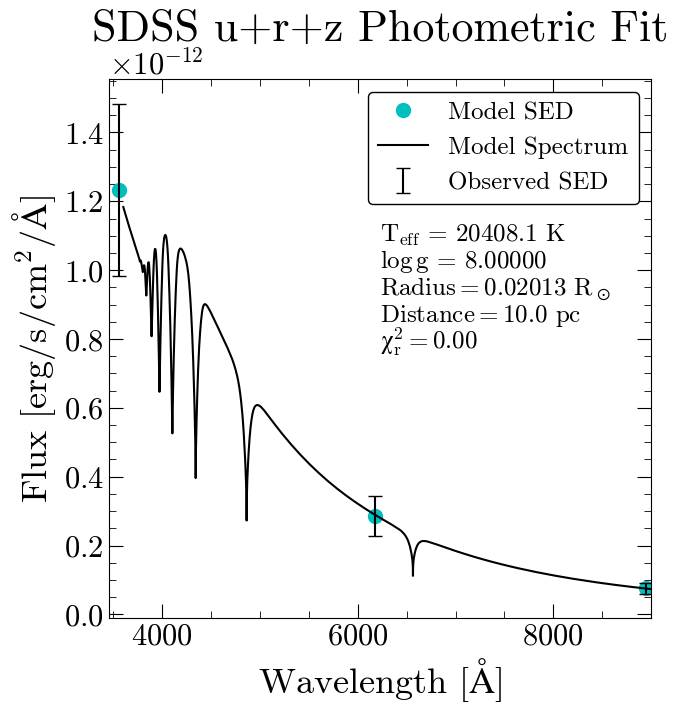

 10%|████▍                                       | 1/10 [00:00<00:07,  1.14it/s]

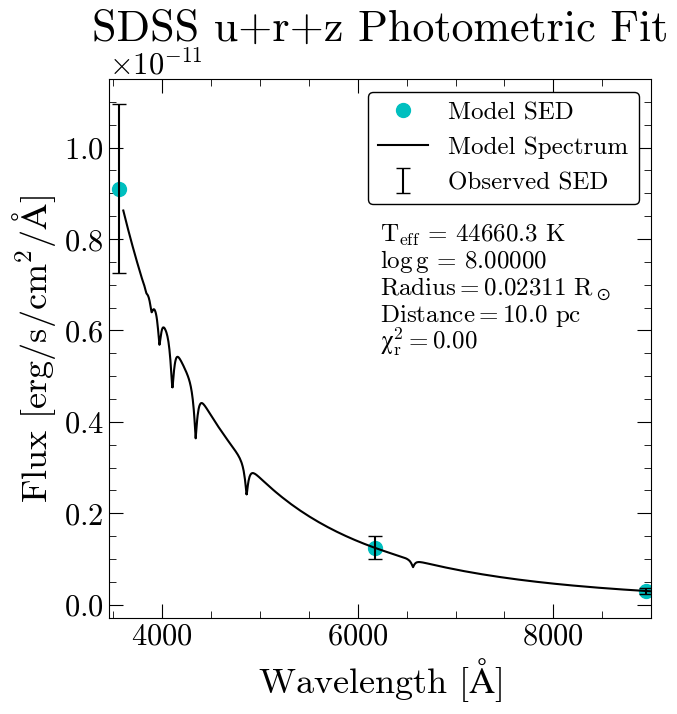

 20%|████████▊                                   | 2/10 [00:01<00:04,  1.87it/s]

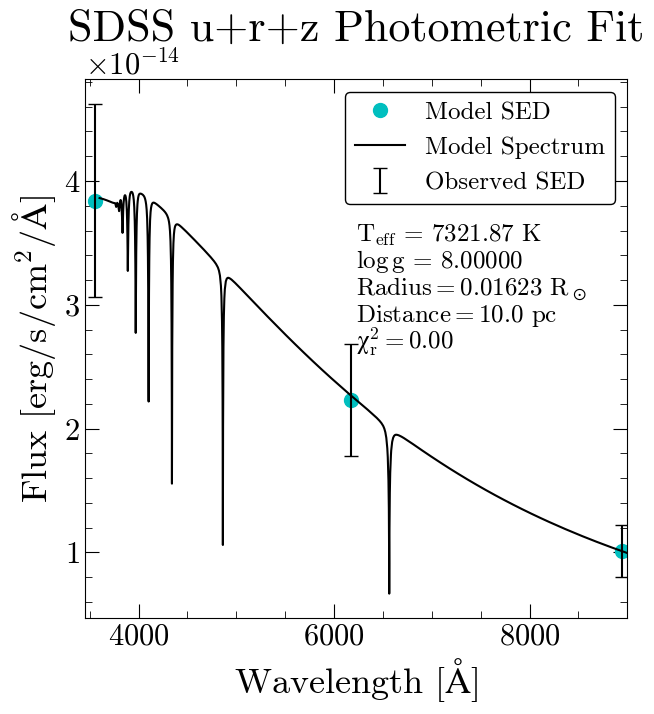

 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.44it/s]

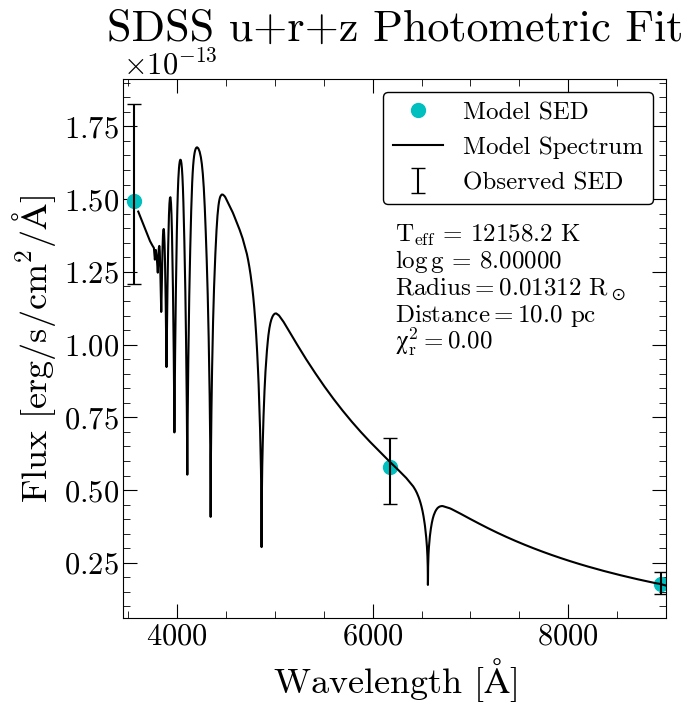

 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.70it/s]

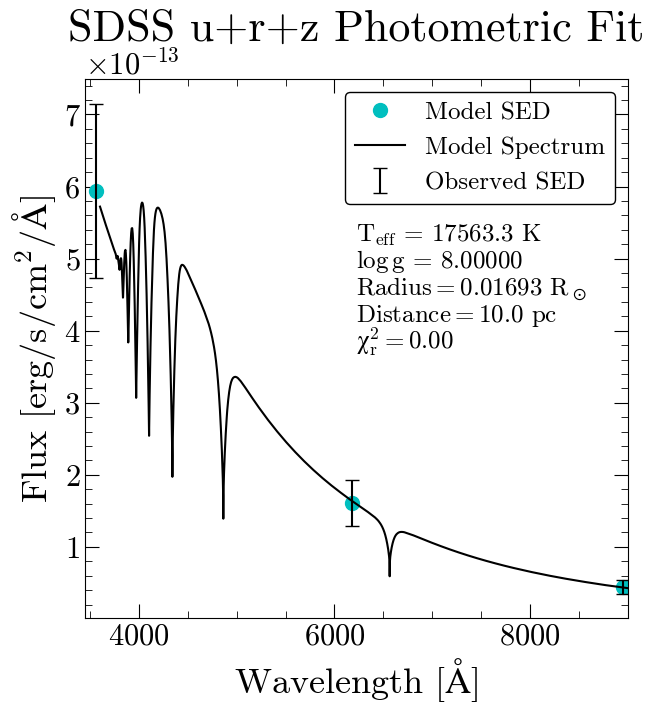

 50%|██████████████████████                      | 5/10 [00:02<00:01,  2.95it/s]

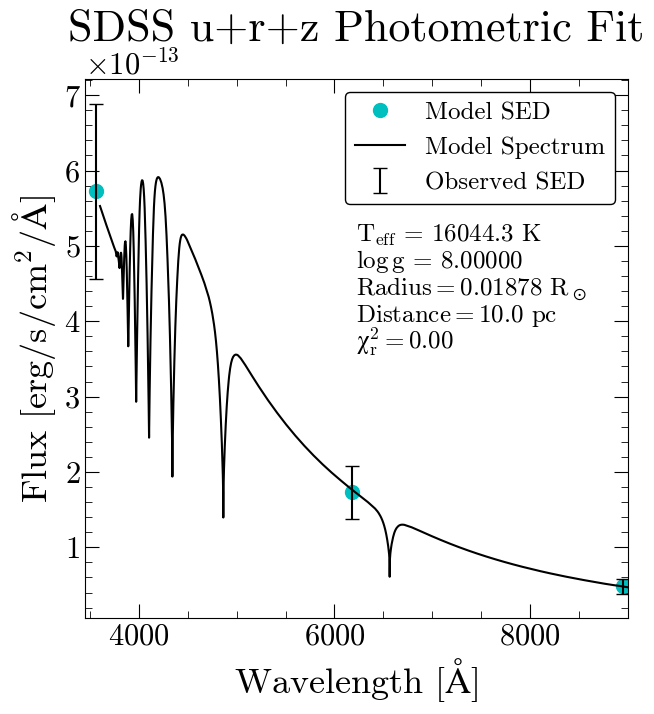

 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  3.12it/s]

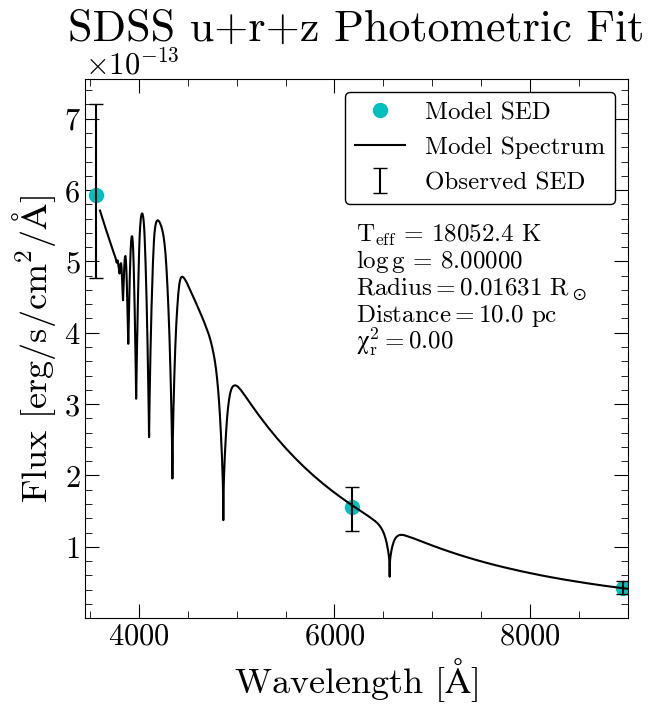

 70%|██████████████████████████████▊             | 7/10 [00:02<00:00,  3.12it/s]

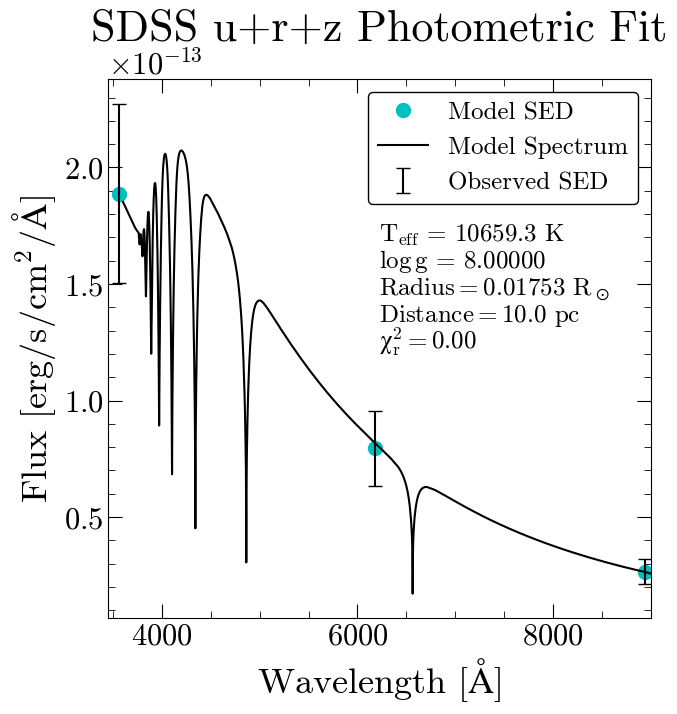

 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  3.23it/s]

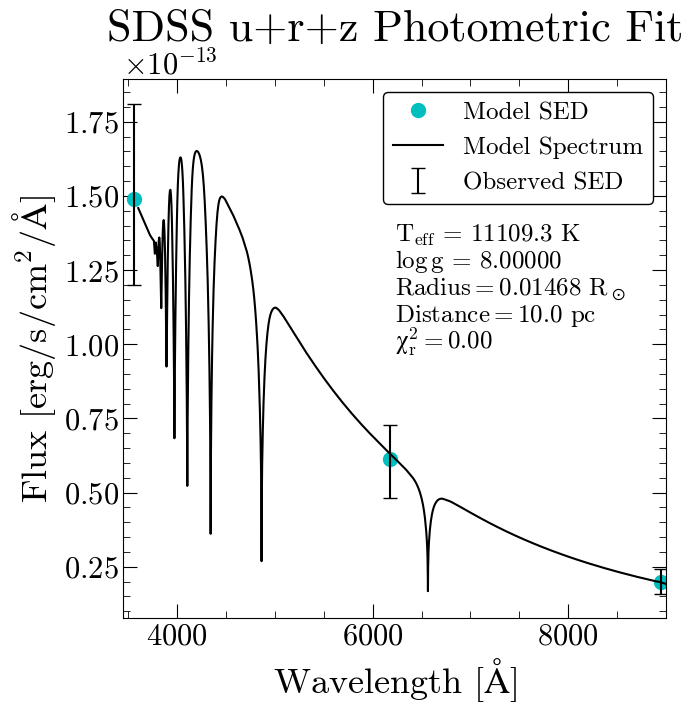

 90%|███████████████████████████████████████▌    | 9/10 [00:03<00:00,  3.25it/s]

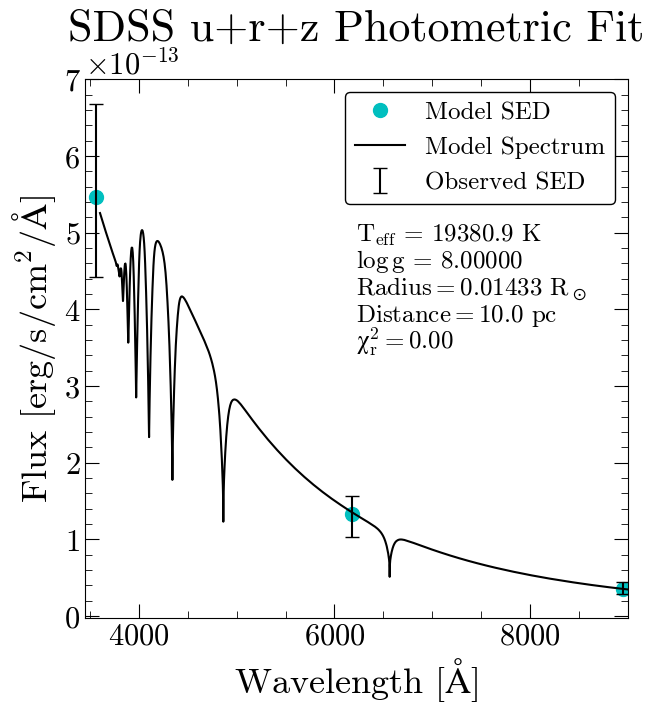

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


In [26]:
#SDSS photometry
#show some fits
test=simulated_wds[:10]
primary_masss=test['primary_mass']
primary_teffs=test['primary_teff']
primary_radiuss=test['primary_radius']
companion_masss=test['companion_mass']
companion_teffs=test['companion_teff']
companion_radiuss=test['companion_radius']

combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs=fit_binary_SDSSphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss,plot=True)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

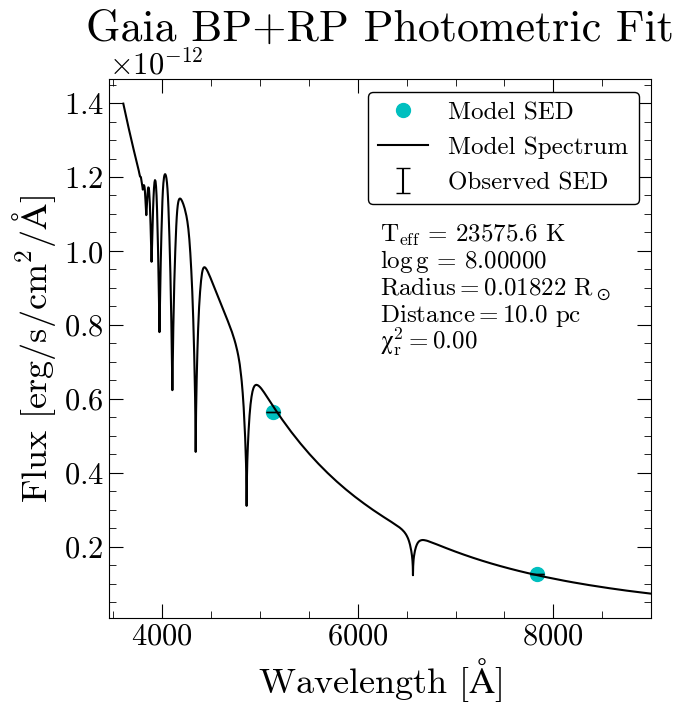

 10%|████▍                                       | 1/10 [00:00<00:04,  2.24it/s]

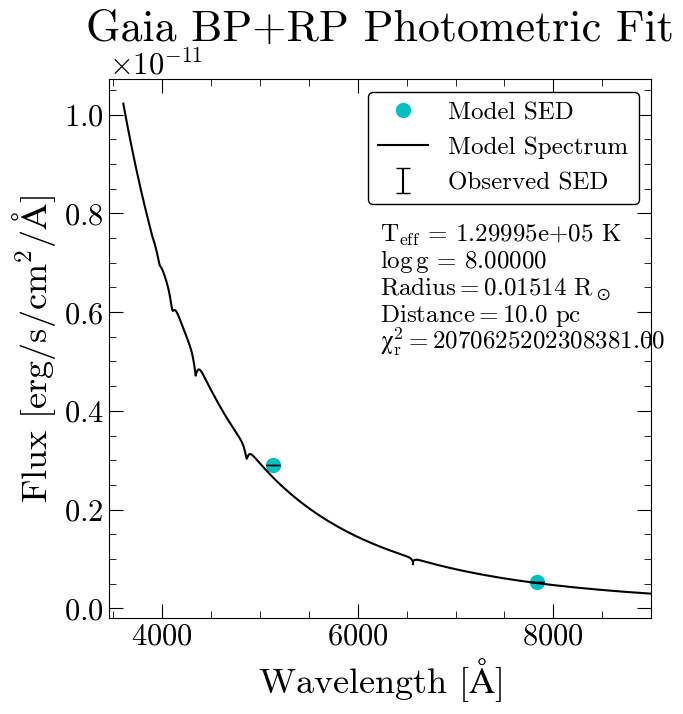

 20%|████████▊                                   | 2/10 [00:00<00:03,  2.36it/s]

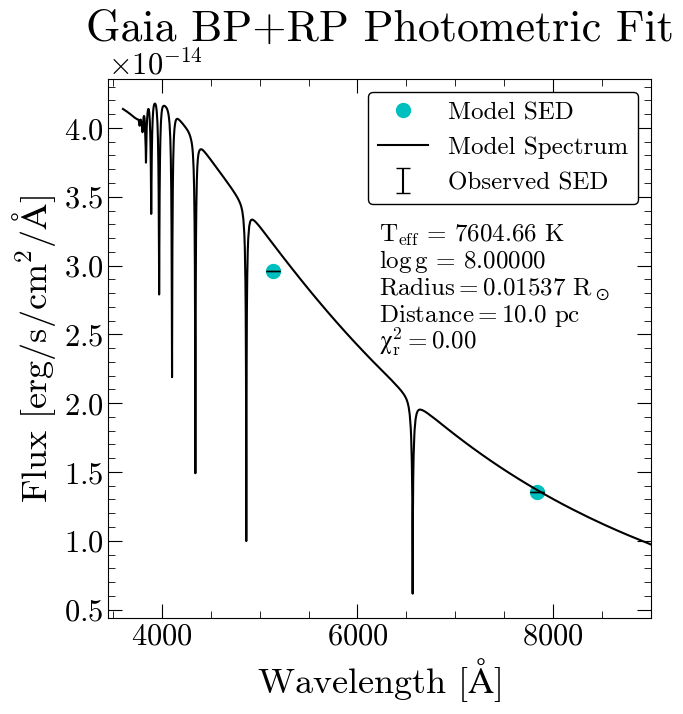

 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.74it/s]

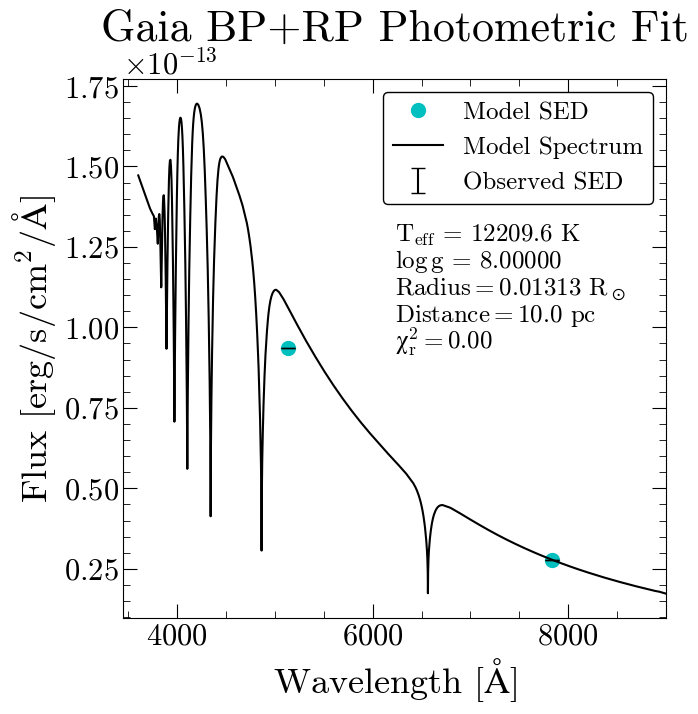

 40%|█████████████████▌                          | 4/10 [00:01<00:02,  2.93it/s]

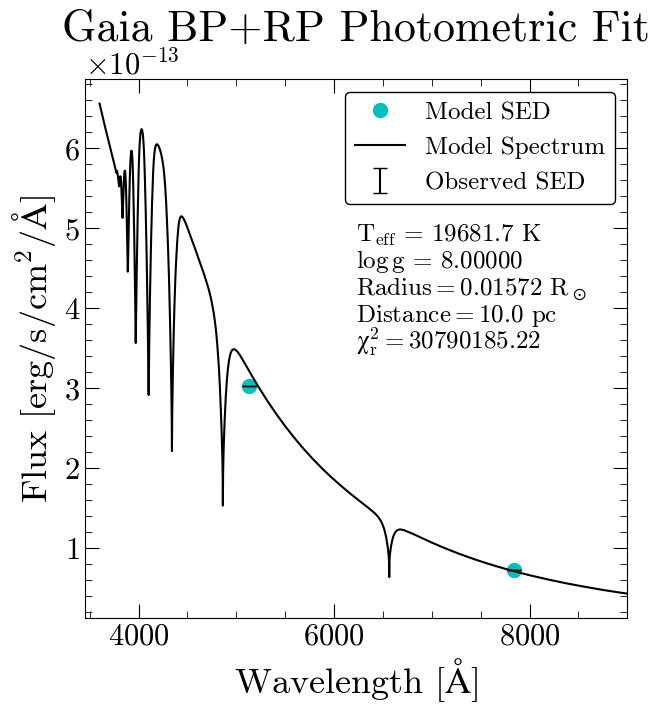

 50%|██████████████████████                      | 5/10 [00:01<00:01,  2.81it/s]

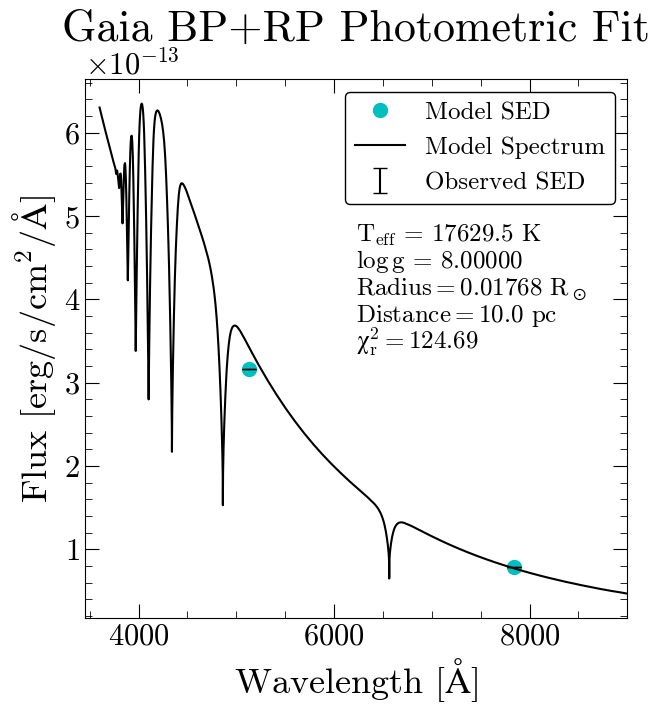

 60%|██████████████████████████▍                 | 6/10 [00:02<00:01,  3.14it/s]

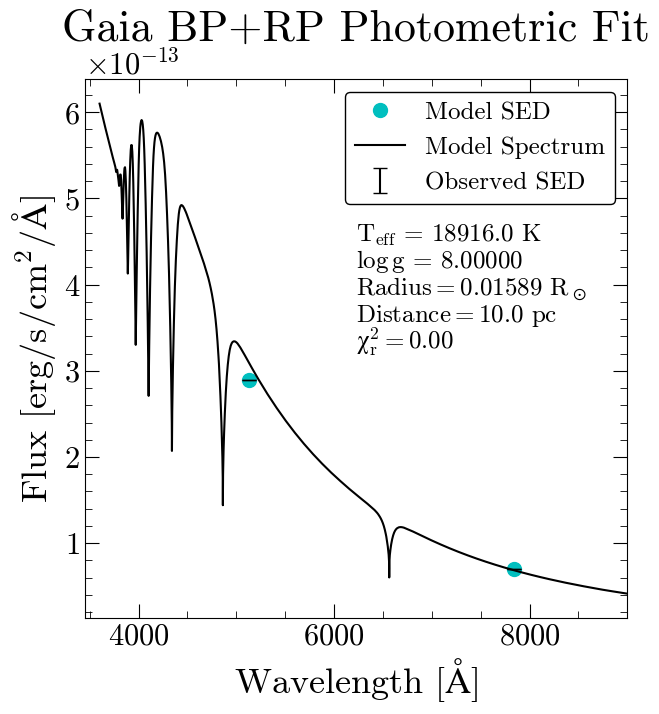

 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  2.75it/s]

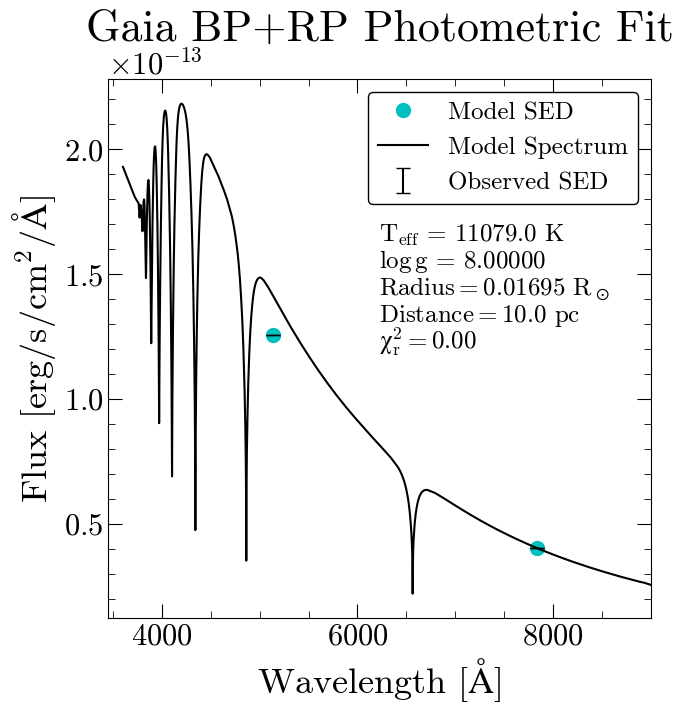

 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  2.98it/s]

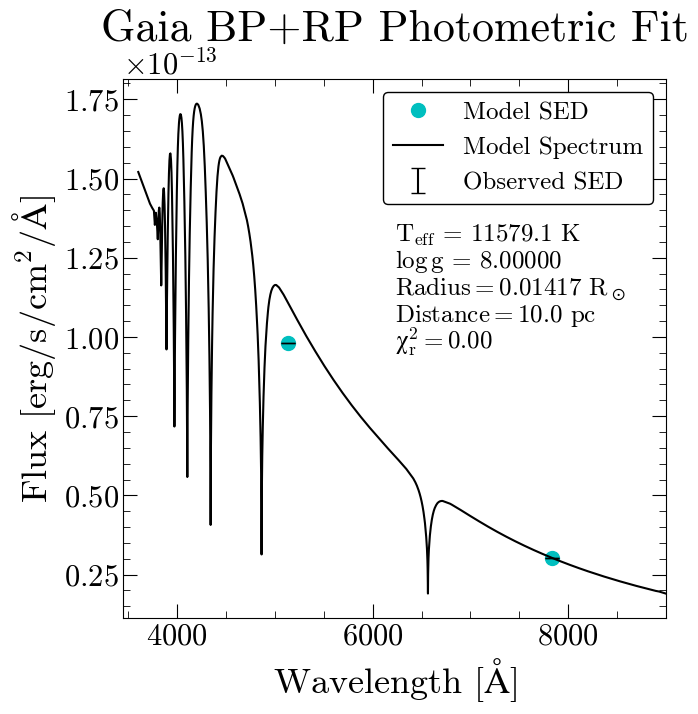

 90%|███████████████████████████████████████▌    | 9/10 [00:03<00:00,  3.18it/s]

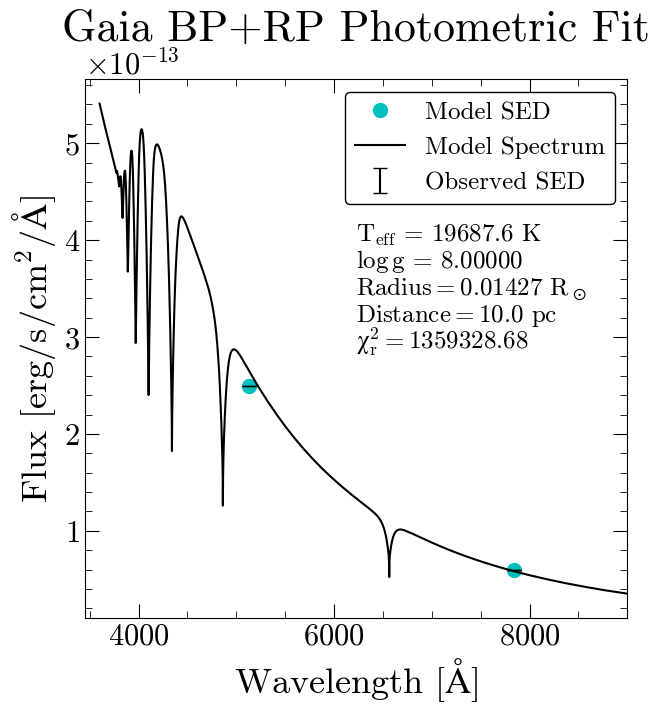

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]


In [27]:
#Gaia photometry
#show some fits
test=simulated_wds[:10]
primary_masss=test['primary_mass']
primary_teffs=test['primary_teff']
primary_radiuss=test['primary_radius']
companion_masss=test['companion_mass']
companion_teffs=test['companion_teff']
companion_radiuss=test['companion_radius']

combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs=fit_binary_Gaiaphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss,plot=True)


# Re-fit the Radii/Teffs for all binary systems and record the apparent Radii/Teffs

In [28]:
#SDSS photometry
primary_masss=simulated_wds['primary_mass']
primary_teffs=simulated_wds['primary_teff']
primary_radiuss=simulated_wds['primary_radius']
companion_masss=simulated_wds['companion_mass']
companion_teffs=simulated_wds['companion_teff']
companion_radiuss=simulated_wds['companion_radius']

combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs=fit_binary_SDSSphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss)

simulated_wds['combined_radius_sdss']=combined_radiuss
simulated_wds['e_combined_radius_sdss']=e_combined_radiuss
simulated_wds['combined_teff_sdss']=combined_teffs
simulated_wds['e_combined_teff_sdss']=e_combined_teffs

100%|█████████████████████████████████████| 10000/10000 [23:57<00:00,  6.96it/s]


In [29]:
#Gaia photometry
#show some fits
primary_masss=simulated_wds['primary_mass']
primary_teffs=simulated_wds['primary_teff']
primary_radiuss=simulated_wds['primary_radius']
companion_masss=simulated_wds['companion_mass']
companion_teffs=simulated_wds['companion_teff']
companion_radiuss=simulated_wds['companion_radius']

combined_radiuss,e_combined_radiuss,combined_teffs,e_combined_teffs=fit_binary_Gaiaphot(primary_masss,primary_teffs,primary_radiuss,companion_masss,companion_teffs,
                        companion_radiuss)

simulated_wds['combined_radius_gaia']=combined_radiuss
simulated_wds['e_combined_radius_gaia']=e_combined_radiuss
simulated_wds['combined_teff_gaia']=combined_teffs
simulated_wds['e_combined_teff_gaia']=e_combined_teffs

100%|█████████████████████████████████████| 10000/10000 [29:05<00:00,  5.73it/s]


In [30]:
#save as a .csv
simulated_wds.to_csv('csv/binaries_effect_sample.csv',index=False)

In [31]:
#read back in
simulated_wds=pd.read_csv('csv/binaries_effect_sample.csv')